# Telco Churn Predictive Analysis

## Project Goal: Helping Telco Founders Predict, Prevent, and Prioritize Churn

This project is built for **telco founders and product leads** who need fast, interpretable insights to reduce churn, protect revenue, and guide retention strategy.

Common Business Problems I Hear:

> *“We know customers are leaving, but we don’t know who, when, or why.
> We don’t have time to dig through dashboards or build predictive models.
> We need clear, actionable insights to prevent churn before it happens.”*

This project explores a fictional telco dataset to uncover churn risk signals, segment-level revenue exposure, and retention opportunities designed to help teams act faster, smarter, and with confidence.

## Business Impact Summary
- Identified high-risk customer segments for targeted retention campaigns
- Quantified revenue at risk to prioritize churn prevention efforts
- Simulated retention impact to guide strategic resource allocation
- Revealed behavioral and contractual churn drivers for proactive outreach
- Delivered founder-grade recommendations aligned with revenue protection and customer lifetime value growth

For those who want to explore the work on Github:

👉 [Telco Churn Predictive Analysis](https://github.com/Wilfrida-Were/Telco-Churn-Predictive-Analysis/blob/main/README.md)

## 📑 Table of Contents
* [Interactive Dashboard](#dashboard)
* [Code](#code)
  * [Data Cleaning](#data-cleaning)
  * [Distributions: Understanding the Data at a Glance](#distributions)
  * [Feature Engineering](#feature)
  * [EDA Churn Breakdown](#eda)
  * [Encoding](#encoding)
  * [Correlation Analysis](#correlation)
  * [Modelling](#model)
  * [Post Model EDA](#postmodeleda)
  * [PostgreSQL: Ingest data](#postgresql)
  * [DBT Views](#views)
  * [Telco Churn Predictive Analysis dashboard documentation](#dashboard-documentation)
* [Key Insights](#key-insights)
* [Recommendations](#recommendations)
* [Client Scenario:Applying the Recommendations](#client-scenario)
* [Who Can Use This Project](#who-can-use-this-project)
* [Tech Stack](#tech-stack)
* [Workflow](#workflow)
* [Let’s Connect](#lets-connect)

<a id="dashboard"></a>
## Interactive Dashboard

👉 [View the Interactive Dashboard on Metabase](http://metabase-dashboard.fly.dev/public/dashboard/833e66ef-1d4d-403a-8cdf-64b16ad82eda)  

Preview (click image to open dashboard):  
[![Telco Churn Dashboard](https://raw.githubusercontent.com/Wilfrida-Were/Telco-Churn-Predictive-Analysis/main/Telco%20Churn%20Predictive%20Analysis.png)](http://metabase-dashboard.fly.dev/public/dashboard/833e66ef-1d4d-403a-8cdf-64b16ad82eda)

<a id="code"></a>
## 💻 Code

In [1]:
# ============================================================
# 📚 IMPORT LIBRARIES
# ============================================================

# Suppress unnecessary warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Core data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Display utilities
from IPython.display import display  # for rich DataFrame rendering in notebooks
from tabulate import tabulate         # for pretty-printing tables

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Ingestion of data to Postgresql
from kaggle_secrets import UserSecretsClient
from sqlalchemy import create_engine, inspect, types, text

In [2]:
# ============================================================
# 📂 LOAD DATASET
# ============================================================

# Load the dataset directly from Kaggle input directory
telco = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Make a working copy to avoid modifying the raw dataset
df = telco.copy() 

# Preview the first 10 rows
display(df.head(10))

# # Data Structure validation (automated workflow demo)
# expected_columns = [
# "customerID", "gender", "SeniorCitizen", "Partner", "Dependents",
#     "tenure", "PhoneService", "MultipleLines", "InternetService",
#     "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
#     "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling",
#     "PaymentMethod", "MonthlyCharges", "TotalCharges", "Churn"
# ]

# # Load new file
# telco = pd.read_csv("path/to/new_file.csv")

# # Make a copy
# df = telco.copy() 

# # Validate schema (order doesn't matter)
# if set(df.columns) == set(expected_columns):
#     print("✅ Schema matches. Proceeding with ingestion.")
#     # Continue with cleaning, prediction, and ingestion
# else:
#     print("❌ Schema mismatch. Skipping ingestion.")
#     # Optionally send alert or log issue

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


<a id="data-cleaning"></a>
## Data Cleaning 

In [3]:
# Preview dataset structure
print("Dataset Overview:")
df.info()  # 7043 rows 21 columns

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

In [4]:
# ============================================================
# DATA CLEANING STEP 1: Fix Data Types
# ============================================================

# Convert TotalCharges" column from object (string) to float
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

# Double-check the conversion worked
print("\n✅ TotalCharges column successfully converted to float.")
print(df['TotalCharges'].head())


✅ TotalCharges column successfully converted to float.
0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64


In [5]:
# ============================================================
# DATA CLEANING STEP 2: Remove Duplicates
# ============================================================

duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"⚠️ Found {duplicates} duplicate rows. Dropping them.")
    df.drop_duplicates(inplace=True)

In [6]:
# ============================================================
# DATA CLEANING STEP 3: Check for Missing Values
# ============================================================

def clean_and_report_missing(df):
    # Step 1: Identify missing values
    missing = df.isnull().sum()
    percent_missing = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Values': missing,
        'Percent Missing': percent_missing.round(2)
    }).sort_values(by='Percent Missing', ascending=False)

    print("\n🔍 Missing Values Summary:")
    print(missing_summary[missing_summary['Missing Values'] > 0])

    # Step 2: General Recommendations
    if missing_summary['Missing Values'].sum() == 0:
        print("\n✅ No missing values detected.")
    else:
        print("\n📣 Recommendations:")
        print("• Review data collection processes to reduce gaps.")
        print("• Encourage responsible data entry and validation.")
        print("• Consider imputation or exclusion based on business context.")
        print("• For numeric columns with known logic, apply calculated imputations where possible.")

    # Step 3: Impute TotalCharges using MonthlyCharges × Tenure
    if 'TotalCharges' in df.columns and df['TotalCharges'].isnull().sum() > 0:
        missing_total = df['TotalCharges'].isnull()
        df.loc[missing_total, 'TotalCharges'] = (
            df.loc[missing_total, 'MonthlyCharges'] * df.loc[missing_total, 'tenure']
        )
        print(f"\n✅ Imputed {missing_total.sum()} missing 'TotalCharges' using MonthlyCharges × Tenure.")

    return df
df = clean_and_report_missing(df)


🔍 Missing Values Summary:
              Missing Values  Percent Missing
TotalCharges              11             0.16

📣 Recommendations:
• Review data collection processes to reduce gaps.
• Encourage responsible data entry and validation.
• Consider imputation or exclusion based on business context.
• For numeric columns with known logic, apply calculated imputations where possible.

✅ Imputed 11 missing 'TotalCharges' using MonthlyCharges × Tenure.


In [7]:
# ============================================================
# DATA CLEANING STEP 4: Unique Values per Column
# ============================================================

unique_counts = df.nunique()

print("\nUnique Value Counts:")
print(unique_counts)

# Quick summary for stakeholders
# Quick summary for stakeholders
print("\n✅ Interpretation:")
print("- Columns with few unique values likely represent categories (e.g. gender, contract type).")
print("- Columns with many unique values may be identifiers or continuous variables (e.g. customer ID, charges).")
print("- This helps us decide which columns to treat as categorical vs. numeric during analysis.")


Unique Value Counts:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

✅ Interpretation:
- Columns with few unique values likely represent categories (e.g. gender, contract type).
- Columns with many unique values may be identifiers or continuous variables (e.g. customer ID, charges).
- This helps us decide which columns to treat as categorical vs. numeric during analysis.


In [8]:
# ============================================================
# DATA CLEANING STEP 5: Tenure Validation
# ============================================================

def check_and_clean_tenure(df):
    zero_tenure_rows = df[df['tenure'] == 0].copy()
    count_zero_tenure = zero_tenure_rows.shape[0]
    percent_zero_tenure = (count_zero_tenure / len(df)) * 100

    if count_zero_tenure > 0:
        print(f"\n⚠️ Found {count_zero_tenure} rows with 'tenure' = 0 ({percent_zero_tenure:.2f}%).")
        print("📣 Recommendation:")
        print("• These entries likely represent new customers with no billing history.")
        print("• For churn analysis and billing logic, it's best to exclude them from modeling.")
        print("• However, retain them for separate EDA to understand onboarding churn.")

        # Create separate DataFrame for tenure = 0
        global df_tenure_zero
        df_tenure_zero = zero_tenure_rows

        # Remove from main DataFrame
        df = df[df['tenure'] != 0]
        print(f"✅ Removed {count_zero_tenure} rows from modeling dataset.")
    else:
        print("\n✅ No rows with 'tenure' = 0 detected.")

    return df
df = check_and_clean_tenure(df)


⚠️ Found 11 rows with 'tenure' = 0 (0.16%).
📣 Recommendation:
• These entries likely represent new customers with no billing history.
• For churn analysis and billing logic, it's best to exclude them from modeling.
• However, retain them for separate EDA to understand onboarding churn.
✅ Removed 11 rows from modeling dataset.


<a id="distributions"></a>
## Distributions: Understanding the Data at a Glance  

📌 Dataset-Level KPIs
Total Customers: 7032
Total Revenue (TotalCharges): $16,056,168.70
Average Monthly Charge: $64.80
Monthly Charge Range: $18.25 - $118.75
Tenure Range: 1 - 72 months



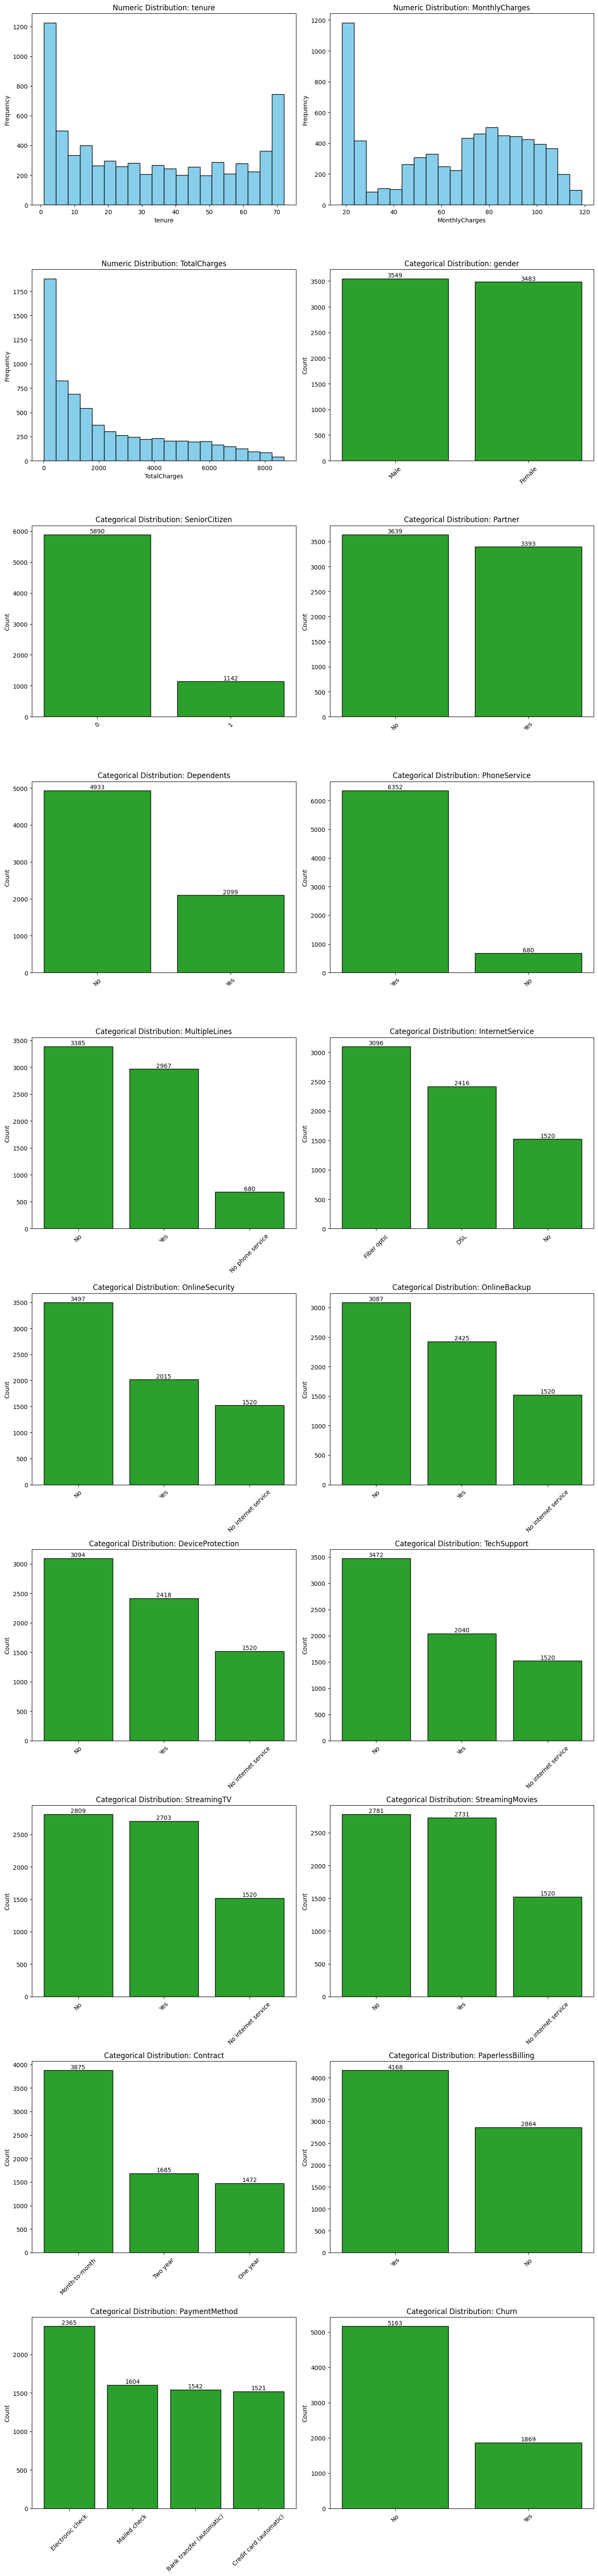

In [9]:
# ============================================================
# KPI CALCULATIONS
# ============================================================

total_customers = df['customerID'].nunique()
total_revenue = df['TotalCharges'].sum()
avg_monthly_charge = df['MonthlyCharges'].mean()
min_monthly_charge = df['MonthlyCharges'].min()
max_monthly_charge = df['MonthlyCharges'].max()
min_tenure = df['tenure'].min()
max_tenure = df['tenure'].max()

print("📌 Dataset-Level KPIs")
print(f"Total Customers: {total_customers}")
print(f"Total Revenue (TotalCharges): ${total_revenue:,.2f}")
print(f"Average Monthly Charge: ${avg_monthly_charge:.2f}")
print(f"Monthly Charge Range: ${min_monthly_charge:.2f} - ${max_monthly_charge:.2f}")
print(f"Tenure Range: {min_tenure} - {max_tenure} months")
print()

# # ===================================================
# # DISTRIBUTIONS: Understanding the Data at a Glance
# # Explore numeric and categorical distributions to spot patterns
# # ===================================================

# --- COLUMN GROUPING ---
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                    'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# --- PLOTTING DISTRIBUTIONS ---
total_plots = len(numeric_cols) + len(categorical_cols)
cols = 2
rows = (total_plots + 1) // cols

plt.figure(figsize=(14, 6*rows))

# Numeric distributions (histograms)
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    plt.hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Numeric Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Categorical distributions (bar charts)
for j, col in enumerate(categorical_cols, len(numeric_cols)+1):
    plt.subplot(rows, cols, j)
    counts = df[col].value_counts()
    bars = plt.bar(counts.index.astype(str), counts.values, color='#2ca02c', edgecolor='black')
    plt.title(f'Categorical Distribution: {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

<a id="feature"></a>
## Feature Engineering

In [10]:
# # ===================================================
# # FEATURE ENGINEERING STEP 1: Combine PhoneService and MultipleLines into a clean, interpretable feature
# # ===================================================

def add_phone_line_status(df):
    df['PhoneLineStatus'] = df.apply(
        lambda row: (
            'No phone service' if row['PhoneService'] == 'No' and row['MultipleLines'] == 'No phone service' else
            'Multiple lines' if row['PhoneService'] == 'Yes' and row['MultipleLines'] == 'Yes' else
            'Single line'
        ),
        axis=1
    )
    return df

# Apply the function
df = add_phone_line_status(df)

# Preview the new column
df[['PhoneService', 'MultipleLines', 'PhoneLineStatus']].head()


# # ===================================================
# # FEATURE ENGINEERING STEP 2: Group InternetService into Yes (Fiber optics & DSL) and No 
# # Count how many of the six internet-related services a customer is actively using
# # ===================================================

# Create binary flag for internet access
df['HasInternet'] = df['InternetService'].map({
    'DSL': 'Yes',
    'Fiber optic': 'Yes',
    'No': 'No'
})

def add_internet_service_count(df):
    service_cols = [
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    
    df['InternetServiceCount'] = df[service_cols].apply(
        lambda row: sum(val == 'Yes' for val in row),
        axis=1
    )
    
    return df
    
# Apply the function
df = add_internet_service_count(df)

# Preview the new column
df[['HasInternet','OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 
    'StreamingTV', 'StreamingMovies','InternetServiceCount']].head()


# # ===================================================
# # FEATURE ENGINEERING STEP 3: Create a readable string that lists the internet type and all 'Yes' services for each customer
# ===================================================

def add_internet_features_string(df):
    service_cols = [
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    
    def build_feature_string(row):
        if row['InternetService'] == 'No':
            return 'No internet'
        
        active_services = [col for col in service_cols if row[col] == 'Yes']
        return f"{row['InternetService']} | " + " | ".join(active_services) if active_services else f"{row['InternetService']} | None"
    
    df['InternetFeatures'] = df.apply(build_feature_string, axis=1)
    
    return df

# Apply the function
df = add_internet_features_string(df)

# Preview the new column
df[['InternetFeatures','InternetServiceCount']].head()

,InternetFeatures,InternetServiceCount
0,DSL | OnlineBackup,1
1,DSL | OnlineSecurity | DeviceProtection,2
2,DSL | OnlineSecurity | OnlineBackup,2
3,DSL | OnlineSecurity | DeviceProtection | Tech...,3
4,Fiber optic | None,0


<a id="eda"></a>
## EDA Churn Breakdown

This section explores churn patterns across two distinct segments:
- **Ongoing Customers** (tenure > 0): Customers with service history, used for modeling
- **New Customers** (tenure = 0): Recently signed up, excluded from modeling but analyzed separately to understand onboarding churn

### Top 10 Churn-Contributing Categories ###


,Feature,Category,ChurnCount,TotalChurn,ShareOfTotalChurn (%)
0,HasInternet,Yes,1756,1869,93.95
1,Contract,Month-to-month,1655,1869,88.55
2,Dependents,No,1543,1869,82.56
3,OnlineSecurity,No,1461,1869,78.17
4,TechSupport,No,1446,1869,77.37
5,PaperlessBilling,Yes,1400,1869,74.91
6,SeniorCitizen,0,1393,1869,74.53
7,InternetService,Fiber optic,1297,1869,69.40
8,OnlineBackup,No,1233,1869,65.97
9,DeviceProtection,No,1211,1869,64.79


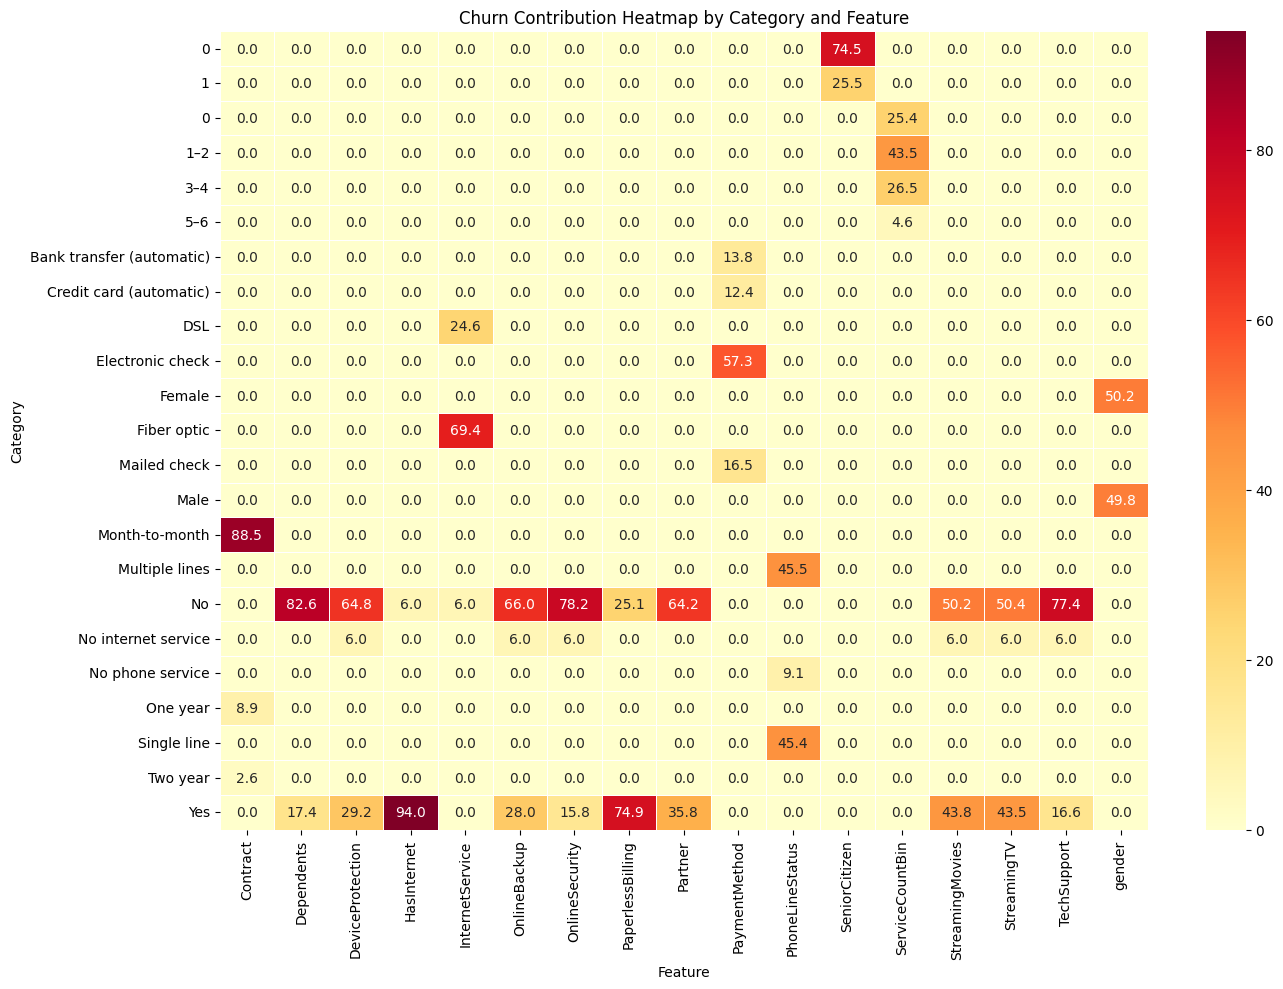

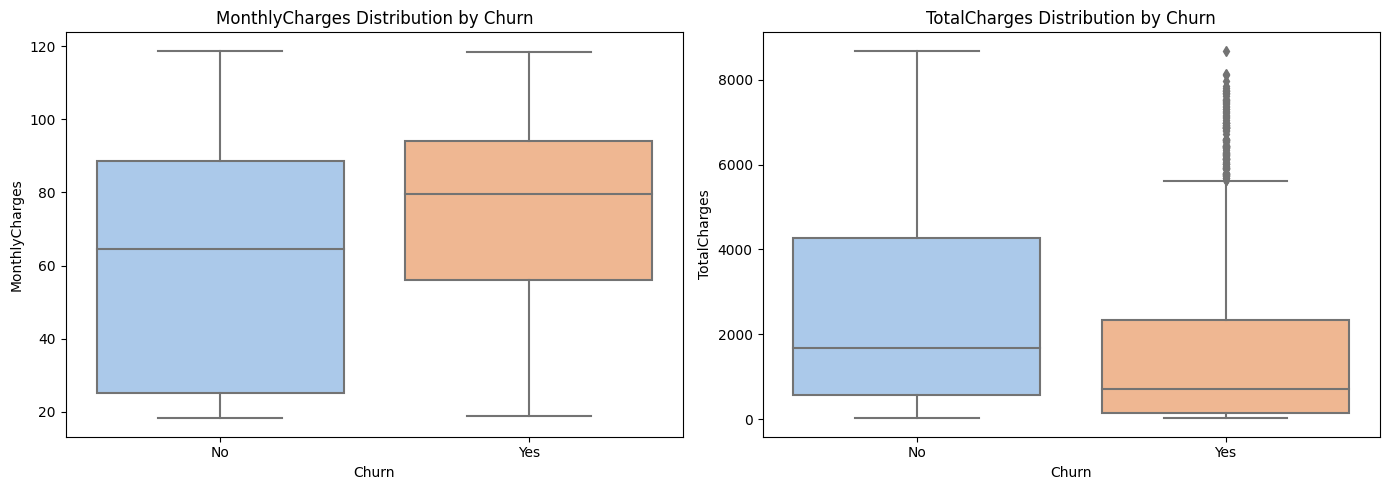


=== Churn Breakdown for gender ===


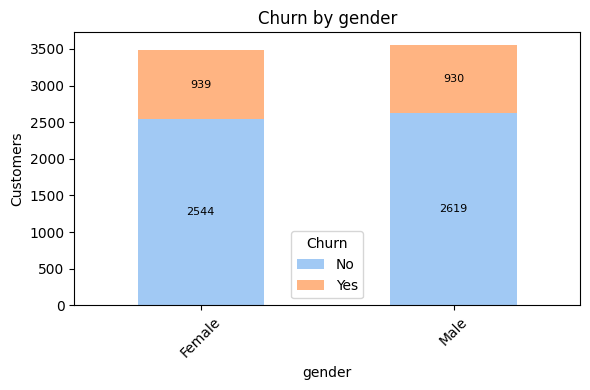

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
gender,,,,,,,
Female,939,2544,3483,939,1869,26.96,50.24
Male,930,2619,3549,930,1869,26.20,49.76



=== Churn Breakdown for SeniorCitizen ===


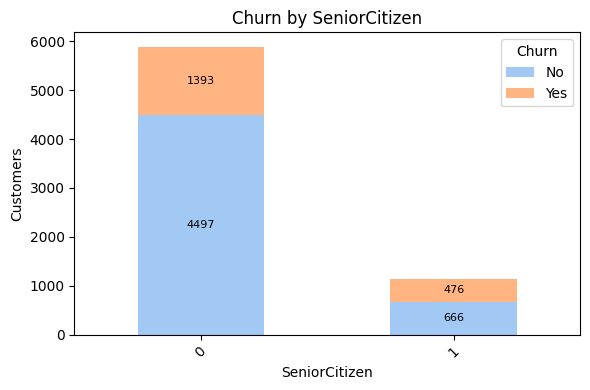

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
SeniorCitizen,,,,,,,
0,1393,4497,5890,1393,1869,23.65,74.53
1,476,666,1142,476,1869,41.68,25.47



=== Churn Breakdown for Partner ===


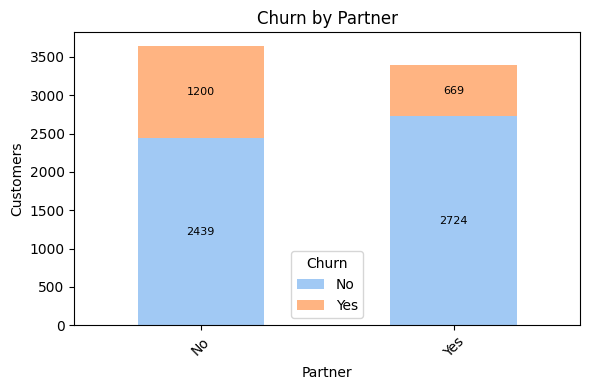

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
Partner,,,,,,,
No,1200,2439,3639,1200,1869,32.98,64.21
Yes,669,2724,3393,669,1869,19.72,35.79



=== Churn Breakdown for Dependents ===


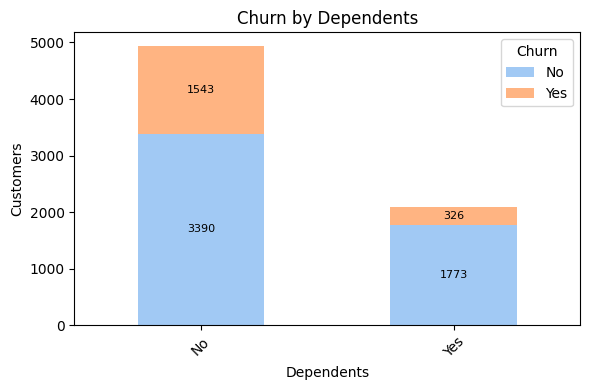

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
Dependents,,,,,,,
No,1543,3390,4933,1543,1869,31.28,82.56
Yes,326,1773,2099,326,1869,15.53,17.44



=== Churn Breakdown for PhoneLineStatus ===


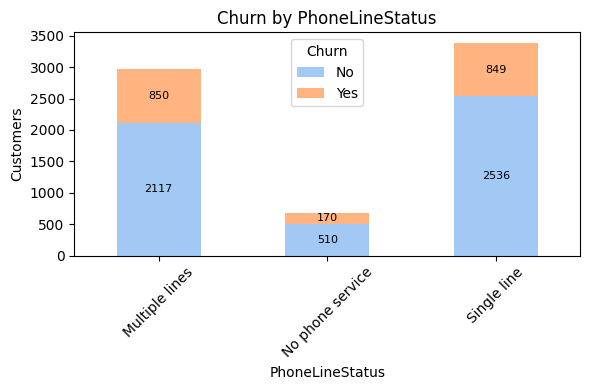

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
PhoneLineStatus,,,,,,,
Multiple lines,850,2117,2967,850,1869,28.65,45.48
Single line,849,2536,3385,849,1869,25.08,45.43
No phone service,170,510,680,170,1869,25.00,9.10



=== Churn Breakdown for InternetService ===


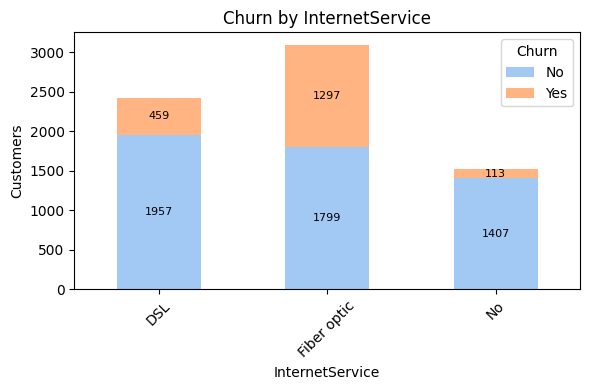

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
InternetService,,,,,,,
Fiber optic,1297,1799,3096,1297,1869,41.89,69.40
DSL,459,1957,2416,459,1869,19.00,24.56
No,113,1407,1520,113,1869,7.43,6.05



=== Churn Breakdown for HasInternet ===


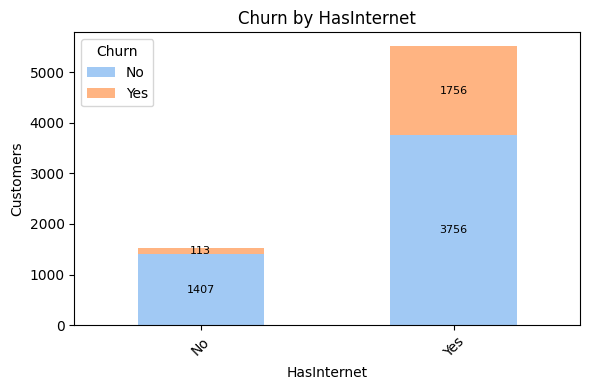

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
HasInternet,,,,,,,
Yes,1756,3756,5512,1756,1869,31.86,93.95
No,113,1407,1520,113,1869,7.43,6.05



=== Churn Breakdown for Contract ===


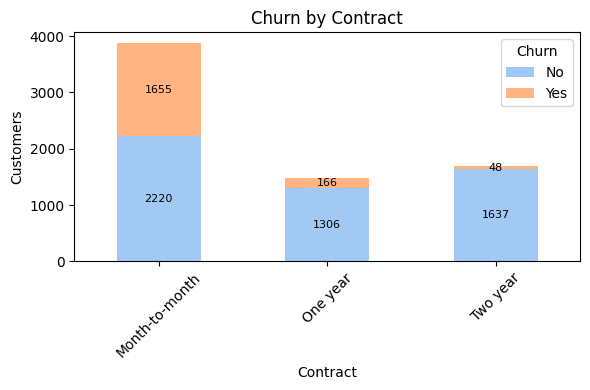

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
Contract,,,,,,,
Month-to-month,1655,2220,3875,1655,1869,42.71,88.55
One year,166,1306,1472,166,1869,11.28,8.88
Two year,48,1637,1685,48,1869,2.85,2.57



=== Churn Breakdown for PaperlessBilling ===


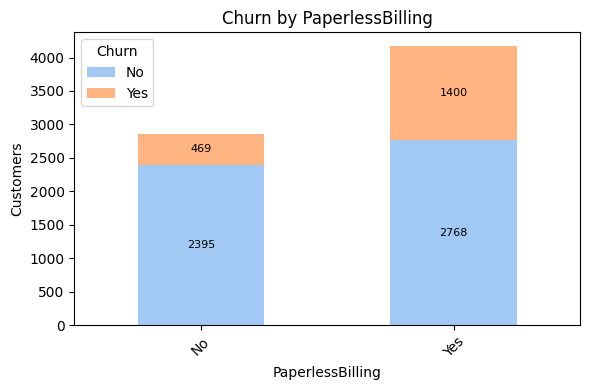

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
PaperlessBilling,,,,,,,
Yes,1400,2768,4168,1400,1869,33.59,74.91
No,469,2395,2864,469,1869,16.38,25.09



=== Churn Breakdown for PaymentMethod ===


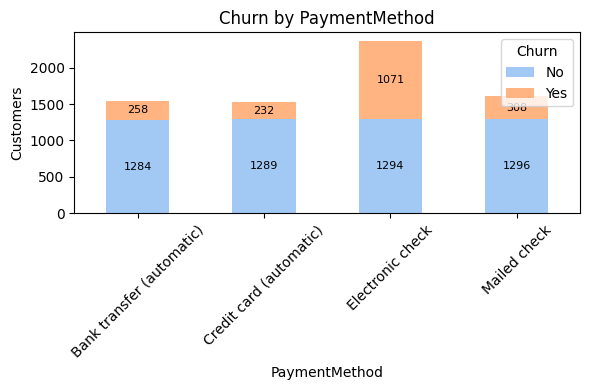

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
PaymentMethod,,,,,,,
Electronic check,1071,1294,2365,1071,1869,45.29,57.30
Mailed check,308,1296,1604,308,1869,19.20,16.48
Bank transfer (automatic),258,1284,1542,258,1869,16.73,13.80
Credit card (automatic),232,1289,1521,232,1869,15.25,12.41



=== Churn Breakdown for OnlineSecurity ===


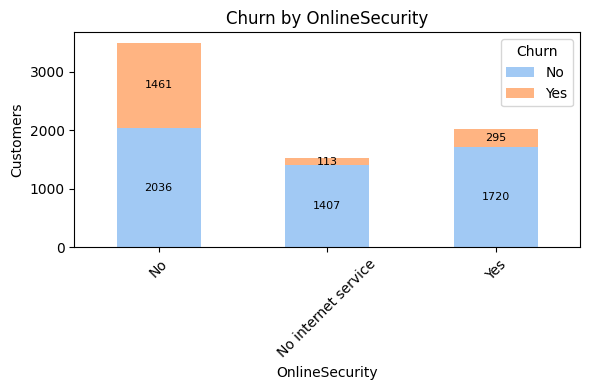

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
OnlineSecurity,,,,,,,
No,1461,2036,3497,1461,1869,41.78,78.17
Yes,295,1720,2015,295,1869,14.64,15.78
No internet service,113,1407,1520,113,1869,7.43,6.05



=== Churn Breakdown for OnlineBackup ===


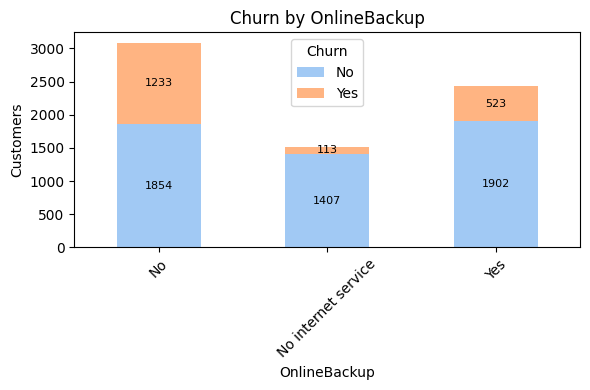

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
OnlineBackup,,,,,,,
No,1233,1854,3087,1233,1869,39.94,65.97
Yes,523,1902,2425,523,1869,21.57,27.98
No internet service,113,1407,1520,113,1869,7.43,6.05



=== Churn Breakdown for DeviceProtection ===


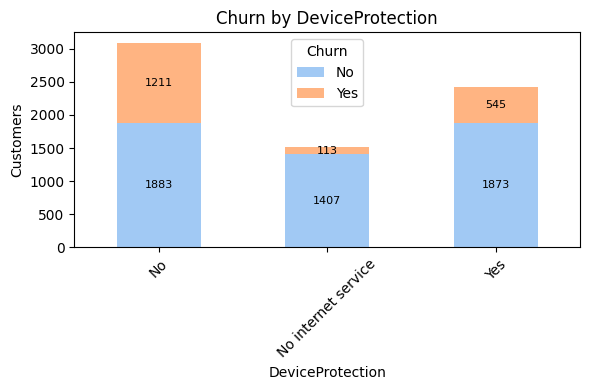

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
DeviceProtection,,,,,,,
No,1211,1883,3094,1211,1869,39.14,64.79
Yes,545,1873,2418,545,1869,22.54,29.16
No internet service,113,1407,1520,113,1869,7.43,6.05



=== Churn Breakdown for TechSupport ===


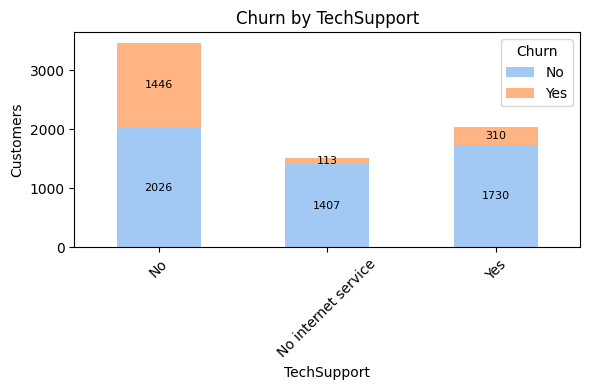

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
TechSupport,,,,,,,
No,1446,2026,3472,1446,1869,41.65,77.37
Yes,310,1730,2040,310,1869,15.20,16.59
No internet service,113,1407,1520,113,1869,7.43,6.05



=== Churn Breakdown for StreamingTV ===


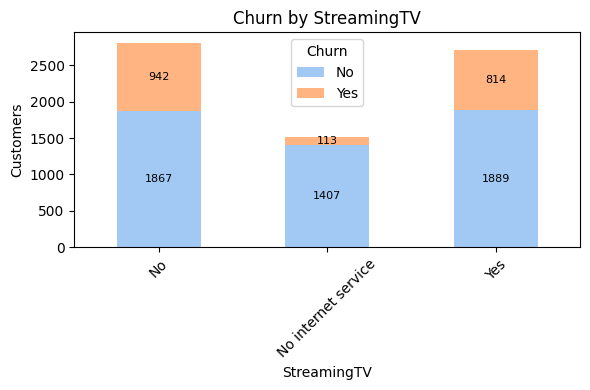

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
StreamingTV,,,,,,,
No,942,1867,2809,942,1869,33.54,50.40
Yes,814,1889,2703,814,1869,30.11,43.55
No internet service,113,1407,1520,113,1869,7.43,6.05



=== Churn Breakdown for StreamingMovies ===


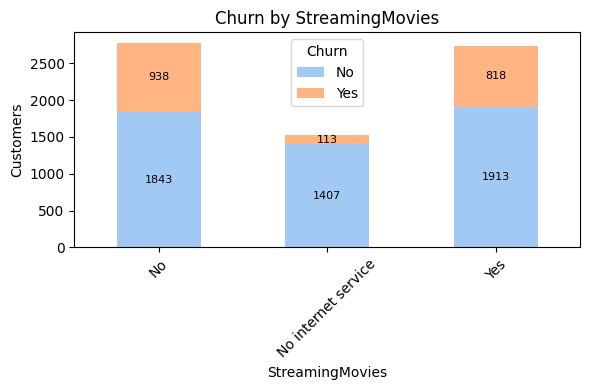

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
StreamingMovies,,,,,,,
No,938,1843,2781,938,1869,33.73,50.19
Yes,818,1913,2731,818,1869,29.95,43.77
No internet service,113,1407,1520,113,1869,7.43,6.05



=== Churn Breakdown for ServiceCountBin ===


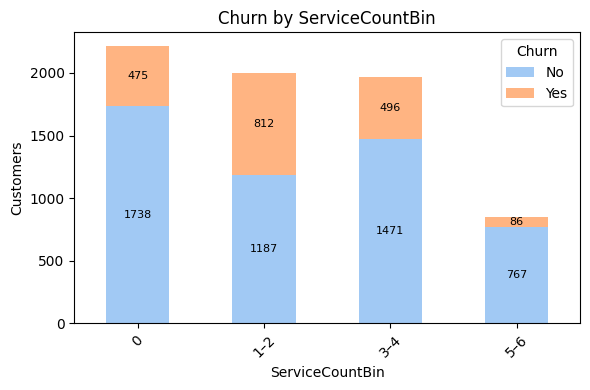

Churn,Yes,No,Total,ChurnCount,TotalChurn,ChurnRate (%),ShareOfTotalChurn (%)
ServiceCountBin,,,,,,,
1–2,812,1187,1999,812,1869,40.62,43.45
3–4,496,1471,1967,496,1869,25.22,26.54
0,475,1738,2213,475,1869,21.46,25.41
5–6,86,767,853,86,1869,10.08,4.60


In [11]:
# ===================================================
# EDA Churn Breakdown Ongoing Customers
# ===================================================

# Step 1: Bin InternetServiceCount into categories
df['ServiceCountBin'] = pd.cut(
    df['InternetServiceCount'],
    bins=[-1, 0, 2, 4, 6],
    labels=['0', '1–2', '3–4', '5–6']
)

# Step 2: Define categorical columns for churn breakdown
categorical_columns = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PhoneLineStatus',
    'InternetService',
    'HasInternet',
    'Contract',
    'PaperlessBilling',
    'PaymentMethod',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'ServiceCountBin'
]

# Step 3: Compute contribution to total churn across all categorical columns
def churn_contribution_summary(df, columns):
    churn_contributions = []
    total_churn = df[df['Churn'] == 'Yes'].shape[0]

    for col in columns:
        churn_counts = df[df['Churn'] == 'Yes'][col].value_counts()
        churn_percent = round((churn_counts / total_churn) * 100, 2)
        temp_df = churn_percent.reset_index()
        temp_df.columns = ['Category', 'ShareOfTotalChurn (%)']
        temp_df['Feature'] = col
        temp_df['ChurnCount'] = churn_counts.values
        temp_df['TotalChurn'] = total_churn
        churn_contributions.append(temp_df)

    return pd.concat(churn_contributions, ignore_index=True)

# Run contribution summary
contribution_df = churn_contribution_summary(df, categorical_columns)

# Step 4: Top 10 churn-heavy categories (table only)
top_contributors = contribution_df.sort_values(by='ShareOfTotalChurn (%)', ascending=False).head(10)

# Display heading and caption
print("### Top 10 Churn-Contributing Categories ###")

# Display table without index
display(top_contributors[['Feature', 'Category', 'ChurnCount', 'TotalChurn', 'ShareOfTotalChurn (%)']].reset_index(drop=True))

# Step 5: Full churn contribution heatmap
pivot_df = contribution_df.pivot(index='Category', columns='Feature', values='ShareOfTotalChurn (%)').fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap='YlOrRd', annot=True, fmt='.1f', linewidths=0.5)
plt.title('Churn Contribution Heatmap by Category and Feature')
plt.xlabel('Feature')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Step 6: Boxplots for MonthlyCharges and TotalCharges vs. Churn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='pastel', ax=axes[0])
axes[0].set_title('MonthlyCharges Distribution by Churn')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('MonthlyCharges')

sns.boxplot(x='Churn', y='TotalCharges', data=df, palette='pastel', ax=axes[1])
axes[1].set_title('TotalCharges Distribution by Churn')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('TotalCharges')

plt.tight_layout()
plt.show()

# Step 7: Stacked bar and churn rate table per column
def churn_rate_table_and_plot(df, column):
    churn_data = df.groupby([column, 'Churn']).size().unstack(fill_value=0)
    churn_data['Total'] = churn_data.sum(axis=1)
    churn_data['ChurnRate (%)'] = round((churn_data['Yes'] / churn_data['Total']) * 100, 2)

    # Add contribution to total churn
    total_churn = df[df['Churn'] == 'Yes'].shape[0]
    churn_data['ShareOfTotalChurn (%)'] = round((churn_data['Yes'] / total_churn) * 100, 2)
    churn_data['ChurnCount'] = churn_data['Yes']
    churn_data['TotalChurn'] = total_churn

    churn_data_sorted = churn_data.sort_values(by='ShareOfTotalChurn (%)', ascending=False)

    # Stacked bar plot
    fig, ax = plt.subplots(figsize=(6, 4))
    churn_data_plot = churn_data[['No', 'Yes']]
    churn_data_plot.plot(kind='bar', stacked=True, ax=ax, color=sns.color_palette('pastel'))
    ax.set_title(f'Churn by {column}')
    ax.set_ylabel('Customers')
    ax.set_xlabel(column)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Churn')

    # Add count labels
    for idx, val in enumerate(churn_data_plot.index):
        y_offset = 0
        for churn_val in churn_data_plot.columns:
            count = churn_data_plot.loc[val, churn_val]
            if count > 0:
                ax.text(idx, y_offset + count / 2, int(count), ha='center', va='center', fontsize=8)
                y_offset += count

    plt.tight_layout()
    plt.show()

    # Display churn rate + contribution table
    display(churn_data_sorted[['Yes', 'No', 'Total', 'ChurnCount', 'TotalChurn', 'ChurnRate (%)', 'ShareOfTotalChurn (%)']])

# Run churn breakdown for all categorical columns
for col in categorical_columns:
    print(f"\n=== Churn Breakdown for {col} ===")
    churn_rate_table_and_plot(df, col)

In [12]:
# ===================================================
# EDA Churn Breakdown New Customers
# ===================================================

# Churn Count Summary for New Customers
total_new_customers = df_tenure_zero.shape[0]
churned_new_customers = df_tenure_zero[df_tenure_zero['Churn'] == 'Yes'].shape[0]
churn_rate_new_customers = round((churned_new_customers / total_new_customers) * 100, 2)

print(f"📊 Total New Customers (tenure = 0): {total_new_customers}")
print(f"⚠️ Churned New Customers: {churned_new_customers}")
print(f"🔍 Churn Rate (New Customers): {churn_rate_new_customers}%")

📊 Total New Customers (tenure = 0): 11
⚠️ Churned New Customers: 0
🔍 Churn Rate (New Customers): 0.0%


<a id="encoding"></a>
## Encoding

**Note:** In one-hot encoding, `1` doesn’t mean “Yes” it means:

> “This row belongs to this specific category.”

**Example: Contract column →**

| Contract_Month-to-month | Contract_One year | Contract_Two year |
|-------------------------|-------------------|-------------------|
| 1                       | 0                 | 0 ← this row had `'Month-to-month'` |
| 0                       | 1                 | 0 ← this row had `'One year'`       |
| 0                       | 0                 | 1 ← this row had `'Two year'`       |

Each row gets a `1` in the column matching its original value. It’s about **category membership**, not binary meaning.

In [13]:
# # ===================================================
# # Encoding
# # Prepare categorical features for modeling using binary and one-hot encoding.
# ===================================================

# Step 1: Define encoding function
def encode_churn_data(df):
    df_encoded = df.copy()

    # Encode churn as binary
    df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

    # Encode binary categorical columns
    binary_cols = ['Partner', 'Dependents', 'PaperlessBilling', 'HasInternet']
    for col in binary_cols:
        df_encoded[col + '_encoded'] = df_encoded[col].map({'Yes': 1, 'No': 0})

    # Encode gender as binary
    df_encoded['gender_encoded'] = df_encoded['gender'].map({'Female': 1, 'Male': 0})

    # One-hot encode multi-category columns
    multi_cat_cols = [
        'PhoneLineStatus',
        'InternetService',
        'Contract',
        'PaymentMethod',
        'OnlineSecurity',
        'OnlineBackup',
        'DeviceProtection',
        'TechSupport',
        'StreamingTV',
        'StreamingMovies'
    ]
    df_encoded = pd.get_dummies(df_encoded, columns=multi_cat_cols, drop_first=False, dtype=int)

    return df_encoded

# Step 2: Create and encode model-specific dataframes
df_model_logreg = encode_churn_data(df)  # For Logistic Regression
df_model_rf = encode_churn_data(df)      # For Random Forest
df_model_xgb = encode_churn_data(df)     # For XGBoost

# Display the 3 dataframes 
display(df_model_logreg.head())
display(df_model_rf.head())
display(df_model_xgb.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,PaperlessBilling,MonthlyCharges,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,Yes,29.85,...,0,1,0,0,1,0,0,1,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,No,56.95,...,1,1,0,0,1,0,0,1,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,Yes,53.85,...,0,1,0,0,1,0,0,1,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,No,42.30,...,1,0,0,1,1,0,0,1,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Yes,70.70,...,0,1,0,0,1,0,0,1,0,0


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,PaperlessBilling,MonthlyCharges,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,Yes,29.85,...,0,1,0,0,1,0,0,1,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,No,56.95,...,1,1,0,0,1,0,0,1,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,Yes,53.85,...,0,1,0,0,1,0,0,1,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,No,42.30,...,1,0,0,1,1,0,0,1,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Yes,70.70,...,0,1,0,0,1,0,0,1,0,0


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,PaperlessBilling,MonthlyCharges,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,Yes,29.85,...,0,1,0,0,1,0,0,1,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,No,56.95,...,1,1,0,0,1,0,0,1,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,Yes,53.85,...,0,1,0,0,1,0,0,1,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,No,42.30,...,1,0,0,1,1,0,0,1,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Yes,70.70,...,0,1,0,0,1,0,0,1,0,0


<a id="correlation"></a>
## Correlation Analysis

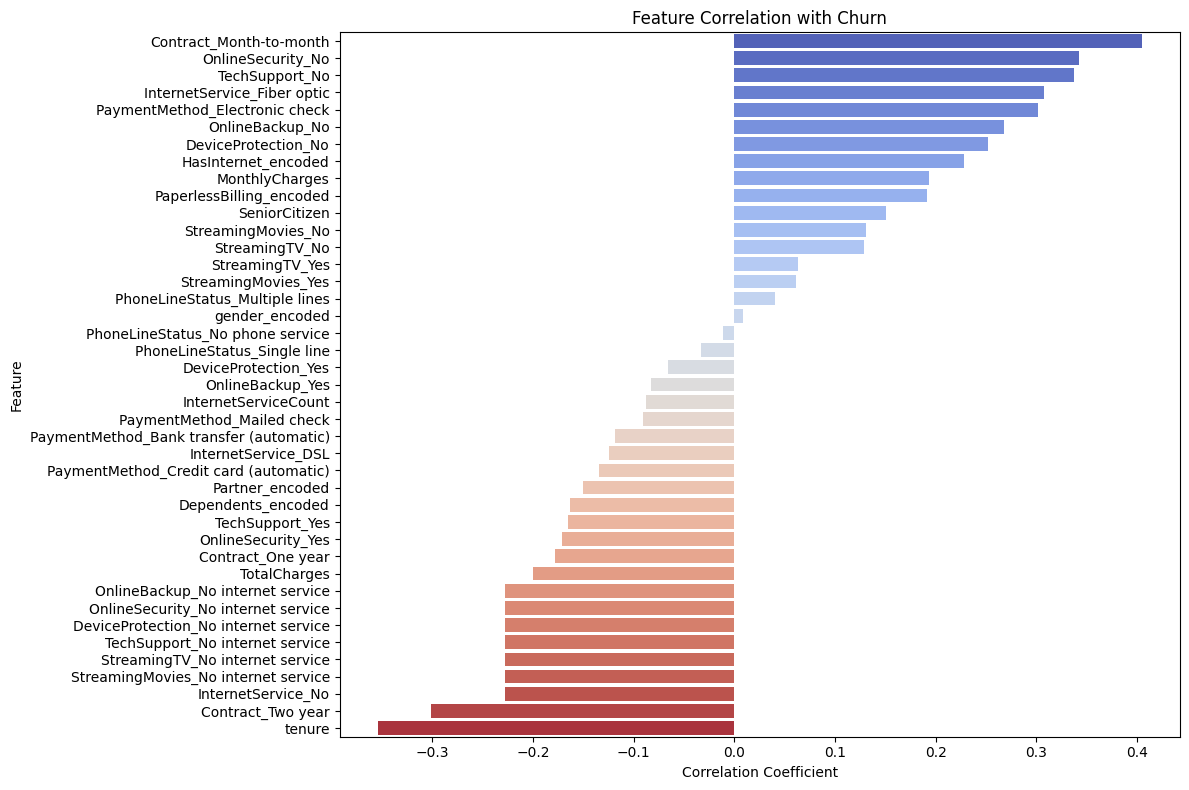

📌 Top 10 Features Most Correlated with Churn


,Feature,CorrelationWithChurn,Interpretation
0,Contract_Month-to-month,0.404565,Positively correlated with churn
1,OnlineSecurity_No,0.342235,Positively correlated with churn
2,TechSupport_No,0.336877,Positively correlated with churn
3,InternetService_Fiber optic,0.307463,Positively correlated with churn
4,PaymentMethod_Electronic check,0.301455,Positively correlated with churn
5,OnlineBackup_No,0.267595,Positively correlated with churn
6,DeviceProtection_No,0.252056,Positively correlated with churn
7,HasInternet_encoded,0.227578,Positively correlated with churn
8,MonthlyCharges,0.192858,Weak or no correlation
9,PaperlessBilling_encoded,0.191454,Weak or no correlation


In [14]:
# ============================================================
# CORRELATION ANALYSIS: Correlation to churn
# Explore relationships between all encoded features and churn
# ============================================================

# Step 1: Select all numeric columns (includes encoded + original numeric)
numeric_cols = df_model_logreg.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Create correlation matrix
correlation_matrix = df_model_logreg[numeric_cols].corr()

# Step 3: Extract correlation with churn
correlation_with_churn = correlation_matrix['Churn'].drop('Churn').sort_values(ascending=False)

# Step 4: Visualize Correlation with Churn
plt.figure(figsize=(12, 8))
sns.barplot(
    x=correlation_with_churn.values,
    y=correlation_with_churn.index,
    palette='coolwarm'
)
plt.title('Feature Correlation with Churn')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Step 5: Create summary table
summary_df = correlation_with_churn.reset_index()
summary_df.columns = ['Feature', 'CorrelationWithChurn']

# Step 6: Add interpretation column
def interpret(row):
    if row['CorrelationWithChurn'] > 0.2:
        return 'Positively correlated with churn'
    elif row['CorrelationWithChurn'] < -0.2:
        return 'Negatively correlated with churn'
    else:
        return 'Weak or no correlation'

summary_df['Interpretation'] = summary_df.apply(interpret, axis=1)

# Step 7: Display top 10 insights
print("📌 Top 10 Features Most Correlated with Churn")
display(summary_df.head(10))

<a id="model"></a>
## Modelling

To predict churn and uncover its drivers, we’ll train and compare three models:

- **Logistic Regression** – baseline and interpretability  
- **Random Forest** – handles feature interactions robustly  
- **XGBoost** – optimized for performance and control

We’ll benchmark them using **AUC, F1-score, precision, and recall**, then use **feature importance** to explain what drives churn.

## Logistic Regression

A simple yet powerful classification model that estimates the probability of churn, predicting whether a customer will leave (`1`) or stay (`0`). Ideal for baseline performance and interpreting key churn drivers.

📊 Classification Report (Model V1):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.64      0.57      0.60       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

📈 ROC AUC Score (Model V1): 0.8358953983776032


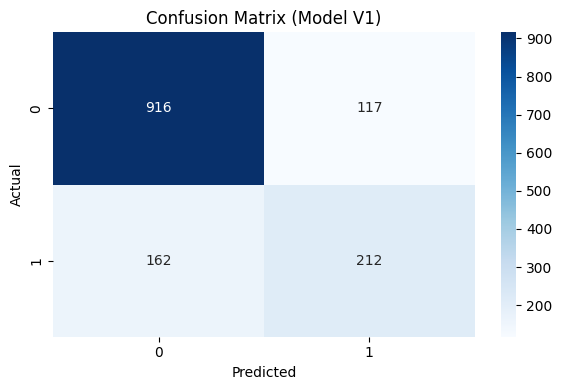

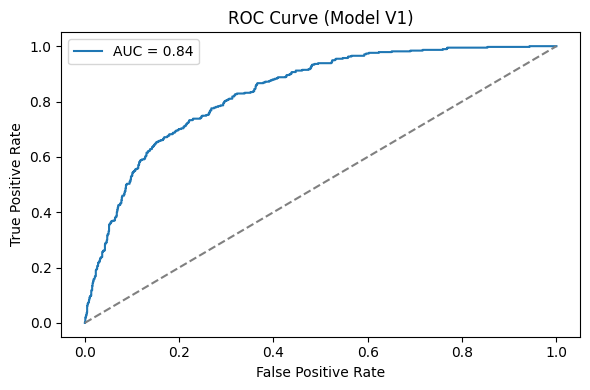

Feature Drivers (Model V1):


,Feature,Coefficient,Abs_Coefficient
16,Contract_Month-to-month,0.615561,0.615561
18,Contract_Two year,-0.575251,0.575251
13,InternetService_DSL,-0.407719,0.407719
14,InternetService_Fiber optic,0.392981,0.392981
12,PhoneLineStatus_Single line,-0.365330,0.365330
7,PaperlessBilling_encoded,0.323872,0.323872
6,Dependents_encoded,-0.252443,0.252443
11,PhoneLineStatus_No phone service,0.246299,0.246299
17,Contract_One year,-0.232599,0.232599
0,SeniorCitizen,0.226581,0.226581



📊 Classification Report (Model V2 Threshold = 0.4):
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1033
           1       0.45      0.87      0.59       374

    accuracy                           0.68      1407
   macro avg       0.69      0.74      0.67      1407
weighted avg       0.80      0.68      0.70      1407

📈 ROC AUC Score (Model V2 Threshold = 0.4): 0.8357737445061629


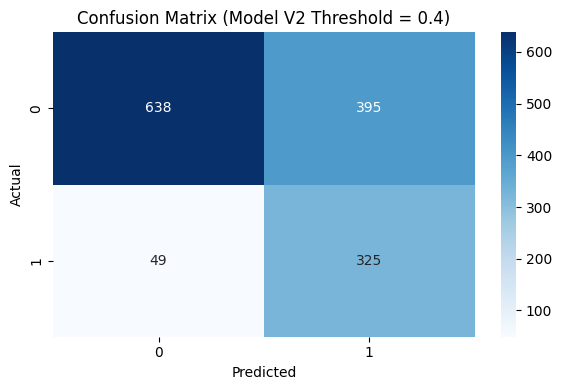

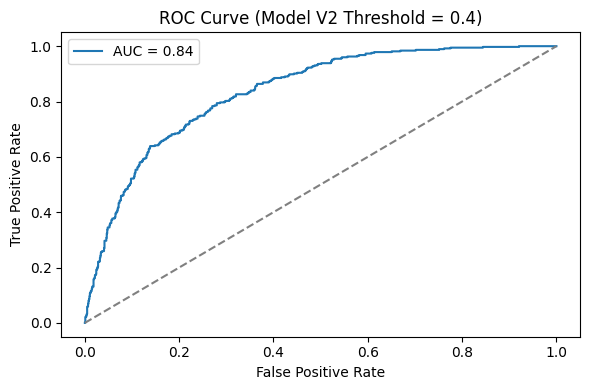

Feature Drivers (Model V2):


,Feature,Coefficient,Abs_Coefficient
16,Contract_Month-to-month,0.668601,0.668601
18,Contract_Two year,-0.506265,0.506265
11,PhoneLineStatus_No phone service,0.334570,0.334570
21,PaymentMethod_Electronic check,0.314176,0.314176
7,PaperlessBilling_encoded,0.309036,0.309036
12,PhoneLineStatus_Single line,-0.292437,0.292437
6,Dependents_encoded,-0.259511,0.259511
0,SeniorCitizen,0.258194,0.258194
14,InternetService_Fiber optic,0.244832,0.244832
32,TechSupport_No,0.232704,0.232704


In [15]:
# ============================================================
# LOGISTIC REGRESSION Model V1: Churn Prediction Baseline
# ============================================================

# Drop categorical columns not used in modeling
drop_cols = [
    'customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'PaperlessBilling', 'HasInternet',
    'InternetFeatures', 'ServiceCountBin'
]

df_model_logreg = df_model_logreg.drop(columns=drop_cols)

# Step 1: Define features and target
X = df_model_logreg.drop(columns=['Churn'])
y = df_model_logreg['Churn']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Initialize and train model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Step 5: Metrics
print("📊 Classification Report (Model V1):")
print(classification_report(y_test, y_pred))
print("📈 ROC AUC Score (Model V1):", roc_auc_score(y_test, y_proba))

# Step 6: Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Model V1)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Step 7: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Model V1)")
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Feature Importance
feature_names = X.columns
coefficients = logreg.coef_[0]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("Feature Drivers (Model V1):")
display(importance_df.head(10))



# ============================================================
# LOGISTIC REGRESSION Model V2: Tuned (class weights + threshold)
# ============================================================

# Step 1: Define features and target
X = df_model_logreg.drop(columns=['Churn'])
y = df_model_logreg['Churn']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Initialize and train model with class weights
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)

# Step 4: Predict probabilities
y_proba = logreg.predict_proba(X)[:, 1]  # Predict on full data for final output

# Step 5: Tune threshold
threshold = 0.4
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Step 6: Add predictions to df_model_logreg
df_model_logreg['churn_probability'] = y_proba
df_model_logreg['churn_prediction'] = y_pred_adjusted
df_model_logreg['prediction_timestamp'] = pd.Timestamp.now()

# Step 7: Metrics on test set
y_test_proba = logreg.predict_proba(X_test)[:, 1]
y_test_pred_adjusted = (y_test_proba >= threshold).astype(int)

print("\n📊 Classification Report (Model V2 Threshold = 0.4):")
print(classification_report(y_test, y_test_pred_adjusted))
print("📈 ROC AUC Score (Model V2 Threshold = 0.4):", roc_auc_score(y_test, y_test_proba))

# Step 8: Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred_adjusted), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Model V2 Threshold = 0.4)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Step 9: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Model V2 Threshold = 0.4)")
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Feature Importance
feature_names = X.columns
coefficients = logreg.coef_[0]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("Feature Drivers (Model V2):")
display(importance_df)

## Random Forest

A model that combines many decision trees to make better predictions. It’s great at spotting patterns and handling complex data without overfitting.

📊 Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

📈 ROC AUC Score: 0.8164385440878807


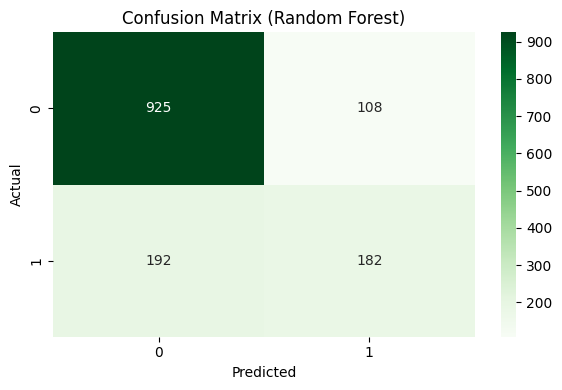

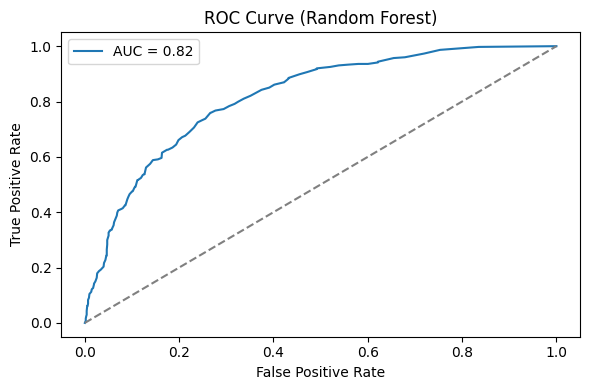

🌲 Top Feature Drivers (Random Forest):


,Feature,Importance
3,TotalCharges,0.153084
2,MonthlyCharges,0.129208
1,tenure,0.127937
16,Contract_Month-to-month,0.067678
23,OnlineSecurity_No,0.041446
18,Contract_Two year,0.038237
32,TechSupport_No,0.032812
14,InternetService_Fiber optic,0.027926
4,InternetServiceCount,0.026834
21,PaymentMethod_Electronic check,0.026126


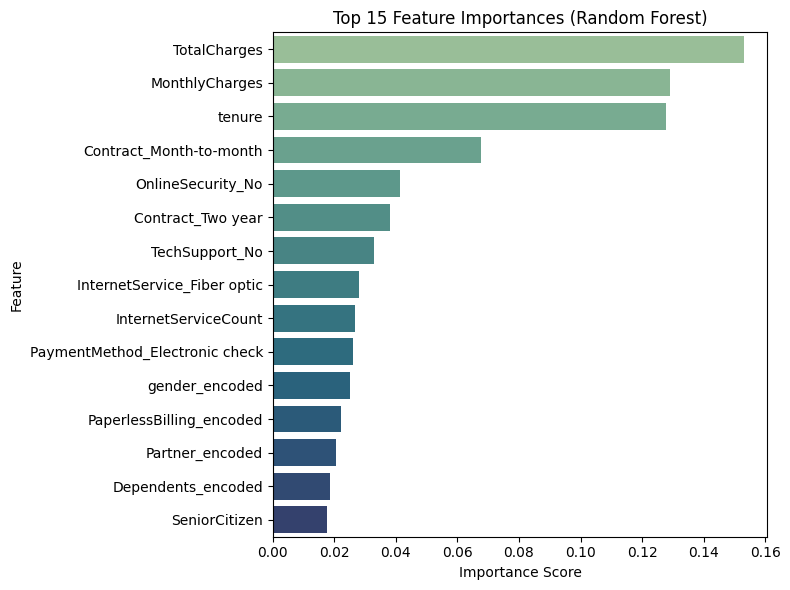

In [16]:
# ============================================================
# RANDOM FOREST
# ============================================================

# Drop categorical columns not used in modeling
drop_cols = [
    'customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'PaperlessBilling', 'HasInternet',
    'InternetFeatures', 'ServiceCountBin'
]
df_model_rf = df_model_rf.drop(columns=drop_cols)

# Step 1: Define features and target
X = df_model_rf.drop(columns=['Churn'])
y = df_model_rf['Churn']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Initialize and train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Step 4: Predict on full data for final output
y_proba_full = rf_model.predict_proba(X)[:, 1]
y_pred_full = rf_model.predict(X)

# Step 5: Store predictions in df_model_rf
df_model_rf['churn_prediction_rf'] = y_pred_full
df_model_rf['churn_probability_rf'] = y_proba_full
df_model_rf['prediction_timestamp_rf'] = pd.Timestamp.now()

# Step 6: Evaluate on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("📊 Classification Report (Random Forest):")
print(classification_report(y_test, y_pred))
print("📈 ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Step 7: Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Step 8: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

# Step 9: Feature Importance
rf_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("🌲 Top Feature Drivers (Random Forest):")
display(rf_importance_df.head(15))

plt.figure(figsize=(8, 6))
sns.barplot(data=rf_importance_df.head(15), x='Importance', y='Feature', palette='crest')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## XGBoost

A fast, powerful model that builds trees in sequence to improve accuracy. Great for handling complex patterns and delivering high-performance churn predictions.

📊 Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.55      0.51      0.53       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.69      1407
weighted avg       0.75      0.76      0.76      1407

📈 ROC AUC Score: 0.8061044359660612


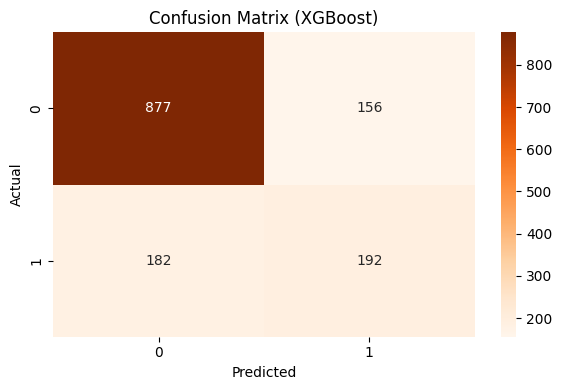

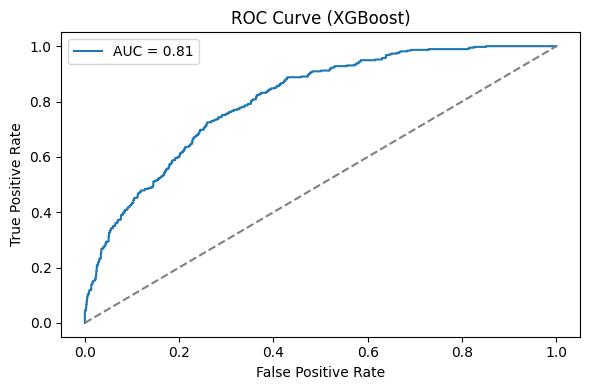

⚡ Top Feature Drivers (XGBoost):


,Feature,Importance
16,Contract_Month-to-month,0.375847
14,InternetService_Fiber optic,0.321681
13,InternetService_DSL,0.026700
23,OnlineSecurity_No,0.020541
32,TechSupport_No,0.020342
18,Contract_Two year,0.016527
11,PhoneLineStatus_No phone service,0.012842
1,tenure,0.011963
17,Contract_One year,0.011471
10,PhoneLineStatus_Multiple lines,0.011441


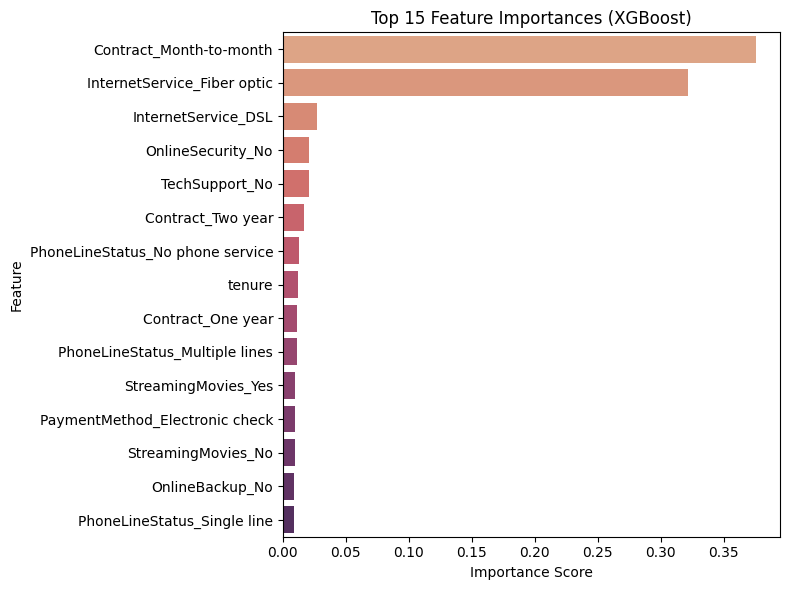

In [17]:
# ============================================================
# XGBoost
# ============================================================

# Step 0: Drop categorical columns not used in modeling
drop_cols = [
    'customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'PaperlessBilling', 'HasInternet',
    'InternetFeatures', 'ServiceCountBin'
]
df_model_xgb = df_model_xgb.drop(columns=drop_cols)

# Step 1: Define features and target
X = df_model_xgb.drop(columns=['Churn'])
y = df_model_xgb['Churn']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Initialize and train model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Step 4: Predict on full data for final output
y_proba_full = xgb_model.predict_proba(X)[:, 1]
y_pred_full = xgb_model.predict(X)

# Step 5: Store predictions in df_model_xgb
df_model_xgb['churn_prediction_xgb'] = y_pred_full
df_model_xgb['churn_probability_xgb'] = y_proba_full
df_model_xgb['prediction_timestamp_xgb'] = pd.Timestamp.now()

# Step 6: Evaluate on test set
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("📊 Classification Report (XGBoost):")
print(classification_report(y_test, y_pred))
print("📈 ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Step 7: Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Step 8: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

# Step 9: Feature Importance
xgb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("⚡ Top Feature Drivers (XGBoost):")
display(xgb_importance_df.head(15))

plt.figure(figsize=(8, 6))
sns.barplot(data=xgb_importance_df.head(15), x='Importance', y='Feature', palette='flare')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Model Selection Summary

We chose **Logistic Regression V2** for its **high recall** and **balanced churn detection**—critical for proactive retention. While Random Forest and XGBoost offer strong precision and AUC, they miss more actual churners.

## 🔍 Why Logistic V2 Was Tuned

Churners are rare but costly to miss.  
To improve detection:
- **Class weights** rebalance attention toward churners  
- **Threshold lowered to 0.4** to flag more at-risk customers

This boosted **recall from 57% to 87%**, making the model more sensitive—even if it sacrifices some precision.

---

## Model Comparison

| Model           | AUC   | Precision (Churn) | Recall (Churn) | F1-score (Churn) |
|----------------|-------|-------------------|----------------|------------------|
| Logistic V1     | 0.84 | Moderate          | Lower          | Lower            |
| **Logistic V2** | 0.84 | Lower             | ✅ Highest     | ✅ Best balance   |
| Random Forest   | 0.82  | ✅ Highest         | Moderate       | Moderate         |
| XGBoost         | 0.81  | Moderate          | Slightly better than RF | Moderate |

---

## Metric Cheat Sheet

- **AUC (Area Under Curve)** → Measures how well the model separates churners from non-churners. Higher = better ranking ability.  
- **Precision** → Of all customers predicted to churn, how many actually did?  
- **Recall** → Of all customers who actually churned, how many did the model catch?  
- **F1-score** → A balance between precision and recall—useful when both matter.

---

## 🎯 Why Recall Matters More

In churn prevention, **missing actual churners (low recall)** means lost revenue.  
We’d rather **flag more customers** (even with some false alarms) than miss those who are quietly leaving.

<a id="postmodeleda"></a>
## Post Model EDA

In [18]:
# ============================================================
# Post Model EDA STEP 1: Transfer final model outputs from df_model_logreg to df
# ============================================================

# Confirm row alignment
assert df.shape[0] == df_model_logreg.shape[0], "Row count mismatch!"

# Transfer final model outputs from df_model_logreg to df
df['churn_probability'] = df_model_logreg['churn_probability'].values
df['churn_prediction'] = df_model_logreg['churn_prediction'].values
df['prediction_timestamp'] = df_model_logreg['prediction_timestamp'].values
df['model_version'] = 'logreg_v2'

# Print the column names of your key dataframes
# Ongoing Customers
print("\n df columns:")
print(df.info())

# New Customers
print("\n df_tenure_zero columns:")
print(df_tenure_zero.info())


 df columns:
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customerID            7032 non-null   object        
 1   gender                7032 non-null   object        
 2   SeniorCitizen         7032 non-null   int64         
 3   Partner               7032 non-null   object        
 4   Dependents            7032 non-null   object        
 5   tenure                7032 non-null   int64         
 6   PhoneService          7032 non-null   object        
 7   MultipleLines         7032 non-null   object        
 8   InternetService       7032 non-null   object        
 9   OnlineSecurity        7032 non-null   object        
 10  OnlineBackup          7032 non-null   object        
 11  DeviceProtection      7032 non-null   object        
 12  TechSupport           7032 non-null   object        
 13  Streaming

In [19]:
# ============================================================
# Post Model EDA STEP 2: Segment-Level Churn Risk Summary
# ============================================================

# Work only with ongoing customers who are ACTIVE. 
# Exlude the CHURN customers to show what we expect from only those who have remained
# df_ongoing = df.copy()
df_ongoing = df[(df['Churn'] != 'Yes')]

# Define categorical features to analyze
segment_features = [
    'Contract', 'PaymentMethod', 'InternetService',
    'OnlineSecurity', 'TechSupport', 'DeviceProtection',
    'SeniorCitizen', 'Partner', 'Dependents'
]

# Total predicted churn across all ongoing customers
total_predicted_churn = df_ongoing['churn_prediction'].sum()

# Aggregate churn metrics per segment
segment_summary = []

for feature in segment_features:
    temp = df_ongoing.groupby(feature).agg(
        AvgChurnProb=('churn_probability', 'mean'),
        HighRiskCount=('churn_probability', lambda x: (x > 0.5).sum()),
        PredictedChurnCount=('churn_prediction', lambda x: (x == 1).sum()),
        TotalCustomers=('churn_prediction', 'count')
    ).reset_index()

    temp['Feature Group'] = feature
    temp.rename(columns={feature: 'Segment Category'}, inplace=True)

    temp['% with >50% Churn Risk'] = (temp['HighRiskCount'] / temp['TotalCustomers'] * 100).round(2)
    temp['% Predicted to Churn'] = (temp['PredictedChurnCount'] / temp['TotalCustomers'] * 100).round(2)
    temp['Share of Total Predicted Churn'] = (temp['PredictedChurnCount'] / total_predicted_churn * 100).round(2)
    temp['Avg Predicted Churn Probability'] = (temp['AvgChurnProb'] * 100).round(2)

    segment_summary.append(temp)

# Combine and sort
segment_df = pd.concat(segment_summary, ignore_index=True)
segment_df = segment_df.sort_values(by='Avg Predicted Churn Probability', ascending=False)

# Reorder columns for presentation
segment_df = segment_df[[
    'Segment Category', 'Feature Group',
    'Avg Predicted Churn Probability',
    'HighRiskCount', '% with >50% Churn Risk',
    'PredictedChurnCount', '% Predicted to Churn',
    'TotalCustomers', 'Share of Total Predicted Churn'
]]

# Rename columns for clarity
segment_df.columns = [
    'Segment Category', 'Feature Group',
    'Avg Predicted Churn Probability (%)',
    'Customers with >50% Churn Risk',
    '% with >50% Churn Risk',
    'Customers Predicted to Churn',
    '% Predicted to Churn',
    'Total Customers in Segment',
    'Share of Total Predicted Churn (%)'
]

# Preview top rows
print(
    "> **Note**: Customers may appear in multiple categories across features "
    "(e.g. Contract, PaymentMethod, TechSupport). This column reflects the percentage "
    "of total predicted churn associated with each category."
    "Totals may exceed 100% due to overlap.\n"
)

segment_df.head(15)

> **Note**: Customers may appear in multiple categories across features (e.g. Contract, PaymentMethod, TechSupport). This column reflects the percentage of total predicted churn associated with each category.Totals may exceed 100% due to overlap.



,Segment Category,Feature Group,Avg Predicted Churn Probability (%),Customers with >50% Churn Risk,% with >50% Churn Risk,Customers Predicted to Churn,% Predicted to Churn,Total Customers in Segment,Share of Total Predicted Churn (%)
0,Month-to-month,Contract,56.02,1344,60.54,1703,76.71,2220,90.63
5,Electronic check,PaymentMethod,54.51,764,59.04,896,69.24,1294,47.68
10,No,OnlineSecurity,51.48,1133,55.65,1319,64.78,2036,70.20
13,No,TechSupport,51.30,1131,55.82,1328,65.55,2026,70.68
8,Fiber optic,InternetService,49.51,895,49.75,1061,58.98,1799,56.47
20,1,SeniorCitizen,48.41,338,50.75,395,59.31,666,21.02
16,No,DeviceProtection,47.20,954,50.66,1123,59.64,1883,59.77
21,No,Partner,39.95,919,37.68,1203,49.32,2439,64.02
23,No,Dependents,37.76,1183,34.90,1537,45.34,3390,81.80
18,Yes,DeviceProtection,29.99,431,23.01,580,30.97,1873,30.87


In [20]:
# ============================================================
# Post Model EDA STEP 3: Column Normalization Cell (Pre-Ingestion)
# ============================================================

import re

def camel_to_snake(name):
    """Convert camelCase or PascalCase to snake_case"""
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

def normalize_dataframe(df):
    df = df.copy()
    df.columns = [camel_to_snake(col) for col in df.columns]
    return df

# Apply normalization
df = normalize_dataframe(df)
df_tenure_zero = normalize_dataframe(df_tenure_zero)

print("✅ Normalized columns in df:")
print(df.columns.tolist())

print("\n✅ Normalized columns in df_tenure_zero:")
print(df_tenure_zero.columns.tolist())

# Convert to Boolean in Python
df['senior_citizen'] = df['senior_citizen'].astype(bool)
df['churn_prediction'] = df['churn_prediction'].astype(bool)
df_tenure_zero['senior_citizen'] = df_tenure_zero['senior_citizen'].astype(bool)

✅ Normalized columns in df:
['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'churn', 'phone_line_status', 'has_internet', 'internet_service_count', 'internet_features', 'service_count_bin', 'churn_probability', 'churn_prediction', 'prediction_timestamp', 'model_version']

✅ Normalized columns in df_tenure_zero:
['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'churn']


<a id="postgresql"></a>
## PostgreSQL: Ingest data

I’ve already created the tables and ingested the data using **Supabase**, which hosts our **PostgreSQL database** in the cloud.  
Credentials are securely stored in **Kaggle Secrets**, accessible via *Add-ons → Secrets* in your notebook.

If you're running this yourself:
- Set up a **PostgreSQL database on Supabase** (no local setup needed)  
- Or connect to an existing PostgreSQL instance (e.g. via VS Code or other tools)  
- Uncomment the code block below  
- Replace credentials with your own Kaggle Secrets and PostgreSQL details
- Run to create and populate the tables

| Table Name         | Purpose                                      |
|--------------------|----------------------------------------------|
| `ongoing_customers` | Tenure ≥ 1, includes churn predictions       |
| `new_customers`     | Tenure = 0, not modeled                      |

---

### Why PostgreSQL?

We use **PostgreSQL** as our warehouse because it’s:
- **Reliable and scalable** for structured data  
- **SQL-native**, making it easy to query, join, and filter  
- **Compatible with Supabase**, Kaggle, and most analytics tools

It acts as our **central store** for predictions and snapshots ready for dashboards, audits, or downstream analysis.

In [21]:
# # ============================================================
# # PostgreSQL Connect and Ingest Data (Supabase)
# # ============================================================

# # ============================================================
# # Install Required Libraries
# # ============================================================
# # pip install sqlalchemy psycopg2 pandas

# # ============================================================
# # PHASE 1: Schema Setup — Create Tables If Missing
# # ============================================================

# # Connect to Supabase
# secrets = UserSecretsClient()
# host = secrets.get_secret("SUPABASE_DB_HOST").strip()
# port = secrets.get_secret("SUPABASE_DB_PORT").strip()
# dbname = secrets.get_secret("SUPABASE_DB_NAME").strip()
# user = secrets.get_secret("SUPABASE_DB_USER").strip()
# password = secrets.get_secret("SUPABASE_DB_PASSWORD").strip()
# engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{dbname}")

# # Table creation SQL
# create_ongoing_sql = '''CREATE TABLE ongoing_customers (
#     customer_id TEXT PRIMARY KEY,
#     gender TEXT,
#     senior_citizen BOOLEAN,
#     partner TEXT,
#     dependents TEXT,
#     tenure INTEGER,
#     phone_service TEXT,
#     multiple_lines TEXT,
#     internet_service TEXT,
#     online_security TEXT,
#     online_backup TEXT,
#     device_protection TEXT,
#     tech_support TEXT,
#     streaming_tv TEXT,
#     streaming_movies TEXT,
#     contract TEXT,
#     paperless_billing TEXT,
#     payment_method TEXT,
#     monthly_charges NUMERIC(12,2),
#     total_charges NUMERIC(12,2),
#     churn TEXT,
#     phone_line_status TEXT,
#     has_internet BOOLEAN,
#     internet_service_count INTEGER,
#     internet_features TEXT,
#     service_count_bin TEXT,
#     churn_probability NUMERIC(5,4),
#     churn_prediction BOOLEAN,
#     prediction_timestamp TIMESTAMP,
#     model_version TEXT,
#     snapshot_timestamp TIMESTAMP
# );'''

# create_new_sql = '''CREATE TABLE new_customers (
#     customer_id TEXT PRIMARY KEY,
#     gender TEXT,
#     senior_citizen BOOLEAN,
#     partner TEXT,
#     dependents TEXT,
#     tenure INTEGER,
#     phone_service TEXT,
#     multiple_lines TEXT,
#     internet_service TEXT,
#     online_security TEXT,
#     online_backup TEXT,
#     device_protection TEXT,
#     tech_support TEXT,
#     streaming_tv TEXT,
#     streaming_movies TEXT,
#     contract TEXT,
#     paperless_billing TEXT,
#     payment_method TEXT,
#     monthly_charges NUMERIC(12,2),
#     total_charges NUMERIC(12,2),
#     churn TEXT,
#     snapshot_timestamp TIMESTAMP
# );'''

# # Create tables if missing
# with engine.begin() as conn:
#     conn.execute(text("SET statement_timeout = 0;"))
#     inspector = inspect(engine)

#     if not inspector.has_table("ongoing_customers"):
#         conn.execute(text(create_ongoing_sql))
#         print("✅ Created table: ongoing_customers")
#     else:
#         print("⚠️ Table ongoing_customers already exists")

#     if not inspector.has_table("new_customers"):
#         conn.execute(text(create_new_sql))
#         print("✅ Created table: new_customers")
#     else:
#         print("⚠️ Table new_customers already exists")

# engine.dispose()
# print("✅ Schema setup complete.")


# # ============================================================
# # PHASE 2: Data Ingestion — Append Snapshot If Not Present
# # ============================================================

# # Prepare DataFrames
# ongoing_customers = df.copy()
# new_customers = df_tenure_zero.copy()
# snapshot_time = pd.Timestamp.now()
# ongoing_customers['snapshot_timestamp'] = snapshot_time
# new_customers['snapshot_timestamp'] = snapshot_time

# # Reconnect to Supabase
# engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{dbname}")

# def append_if_new_snapshot(df, table_name):
#     with engine.connect() as conn:
#         conn.execute(text("SET statement_timeout = 0;"))
#         result = conn.execute(text(f'''
#             SELECT COUNT(*) FROM {table_name}
#             WHERE snapshot_timestamp = :snapshot
#         '''), {"snapshot": df['snapshot_timestamp'].iloc[0]})
#         count = result.scalar()

#         if count == 0:
#             df.to_sql(table_name, engine, if_exists='append', index=False)
#             print(f"✅ Snapshot appended to {table_name}")
#         else:
#             print(f"⚠️ Snapshot already exists in {table_name}. Skipping append.")

# # Run ingestion
# append_if_new_snapshot(ongoing_customers, "ongoing_customers")
# append_if_new_snapshot(new_customers, "new_customers")

# engine.dispose()
# print("✅ Data ingestion complete.")

<a id="views"></a>
## DBT Views

| View Name | Purpose |
|-----------|---------|
| `v_ongoing_customers` | Enriched ongoing customers with churn prediction, risk segments, and filterable dimensions |
| `v_new_customers` | Enriched new customers with service breakdowns, tenure bins, and churn status |

---

### `v_ongoing_customers`

```sql
{{ config(materialized='view') }}

WITH enriched AS (
  SELECT
    "customer_id",
    "gender",
    CASE 
      WHEN "senior_citizen" = TRUE THEN 'Senior'
      ELSE 'Young'
    END AS age_group,
    "partner",
    "dependents",
    "tenure",
    CASE 
      WHEN "tenure" < 6 THEN '0 to 6 months'
      WHEN "tenure" < 12 THEN '6 to 12 months'
      ELSE '12+ months'
    END AS tenure_bin,
    "phone_service",
    "multiple_lines",
    "internet_service",
    "online_security",
    "online_backup",
    "device_protection",
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "contract",
    "paperless_billing",
    "payment_method",
    "monthly_charges",
    "total_charges",
    "phone_line_status",
    "internet_service_count",
    "internet_features",
    "service_count_bin" AS internet_service_bin,
    "churn_probability",
    "prediction_timestamp",
    "prediction_timestamp"::date AS prediction_date,
    "model_version",
    "snapshot_timestamp",
    "snapshot_timestamp"::date AS snapshot_date,
    "churn",
    "churn_prediction",
    CASE WHEN "churn" = 'Yes' THEN 'Churn' ELSE 'Active' END AS actual_churn_status,
    CASE 
      WHEN "churn_prediction" = FALSE THEN 'No Risk'
      WHEN "churn_probability" >= 0.8 THEN 'High Risk'
      WHEN "churn_probability" >= 0.5 THEN 'Medium Risk'
      ELSE 'Low Risk'
    END AS churn_risk_segment,
    CASE 
      WHEN "churn_prediction" = TRUE THEN 'Likely to churn' 
      ELSE 'Not likely to churn'
    END AS predicted_churn_status
  FROM public.ongoing_customers
)

SELECT *
FROM enriched
```

---

### `v_new_customers`

```sql
{{ config(materialized='view') }}

WITH enriched AS (
  SELECT
    "customer_id",
    "gender",
    CASE 
      WHEN "senior_citizen" = TRUE THEN 'Senior'
      ELSE 'Young'
    END AS age_group,
    "partner",
    "dependents",
    "tenure",
    CASE 
      WHEN "tenure" < 6 THEN '0 to 6 months'
      WHEN "tenure" < 12 THEN '6 to 12 months'
      ELSE '12+ months'
    END AS tenure_bin,
    "phone_service",
    "multiple_lines",
    "internet_service",
    "online_security",
    "online_backup",
    "device_protection",
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "contract",
    "paperless_billing",
    "payment_method",
    "monthly_charges",
    "total_charges",
    CASE
      WHEN "phone_service" = 'No' AND "multiple_lines" = 'No phone service' THEN 'No phone service'
      WHEN "phone_service" = 'Yes' AND "multiple_lines" = 'Yes' THEN 'Multiple lines'
      ELSE 'Single line'
    END AS phone_line_status,
    (
      CASE WHEN "online_security" = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN "online_backup" = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN "device_protection" = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN "tech_support" = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN "streaming_tv" = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN "streaming_movies" = 'Yes' THEN 1 ELSE 0 END
    ) AS internet_service_count,
    CONCAT(
      "internet_service", ' | ',
      CASE WHEN "online_security" = 'Yes' THEN 'OnlineSecurity, ' ELSE '' END,
      CASE WHEN "online_backup" = 'Yes' THEN 'OnlineBackup, ' ELSE '' END,
      CASE WHEN "device_protection" = 'Yes' THEN 'DeviceProtection, ' ELSE '' END,
      CASE WHEN "tech_support" = 'Yes' THEN 'TechSupport, ' ELSE '' END,
      CASE WHEN "streaming_tv" = 'Yes' THEN 'StreamingTV, ' ELSE '' END,
      CASE WHEN "streaming_movies" = 'Yes' THEN 'StreamingMovies' ELSE '' END
    ) AS internet_features,
    CASE
      WHEN (
        CASE WHEN "online_security" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "online_backup" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "device_protection" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "tech_support" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "streaming_tv" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "streaming_movies" = 'Yes' THEN 1 ELSE 0 END
      ) = 0 THEN '0'
      WHEN (
        CASE WHEN "online_security" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "online_backup" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "device_protection" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "tech_support" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "streaming_tv" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "streaming_movies" = 'Yes' THEN 1 ELSE 0 END
      ) BETWEEN 1 AND 2 THEN '1–2'
      WHEN (
        CASE WHEN "online_security" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "online_backup" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "device_protection" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "tech_support" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "streaming_tv" = 'Yes' THEN 1 ELSE 0 END +
        CASE WHEN "streaming_movies" = 'Yes' THEN 1 ELSE 0 END
      ) BETWEEN 3 AND 4 THEN '3–4'
      ELSE '5–6'
    END AS internet_service_bin,
    "snapshot_timestamp",
    "snapshot_timestamp"::date AS snapshot_date,
    CASE WHEN "churn" = 'Yes' THEN 'Drop-off' ELSE 'Active' END AS actual_churn_status
  FROM public.new_customers
)

SELECT *
FROM enriched
```

<a id="dashboard-documentation"></a>
## Telco Churn Predictive Analysis dashboard documentation

### KPIs (Top-Level Cards)

| KPI | Description |
|-----|-------------|
| **Total Revenue** | Combined revenue from ongoing and new customers to date. |
| **Revenue Lost** | Revenue lost from customers who have already churned. |
| **Revenue at Risk** | Revenue tied to active ongoing customers predicted to churn. |
| **Expected Churn Rate** | % of ongoing customers flagged by the model as likely to churn. |
| **Total Customers** | Sum of ongoing and new customers. |
| **Ongoing Customers** | Customers with tenure >= 1 |
| **New Customers** | Customers with tenure = 0 (recently acquired). |
| **Actual Churn Rate** | % of ongoing customers who have already churned. |

### Filters

| Filter | Description |
|--------|-------------|
| **Date** | Filters the dashboard by snapshot timestamp|
| **Churn Risk** | Segments customers into High, Medium, Low risk, No risk groups. |
| **Contract** | Filters customers by contract (e.g. Month-to-month, One-year) |
| **Tenure** | Groups customers by subscription duration. |
| **Gender** | Enables demographic churn analysis. |
| **Age Group** | Segments customers into Senior vs Young.|
| **Payment Method** | Groups customers by payment method (e.g Mailed Check, Electronic check) |
| **Churn Reduction Rate (0.1 – 1.0)** | Simulates retention impact by adjusting the expected churn reduction rate. Default is 0.5 (50% reduction) |

## Visuals

### 1. **Customer Churn Status**
Shows active vs churned customers to highlight retention opportunity.

### 2. **Churn Risk Distribution**
Segments active ongoing customers by churn risk level.

### 3. **Expected Churn Among Active Customers**
Flags which active customers are likely to churn.

### 4. **Customer Breakdown Table**
Tabular view of enriched ongoing customer details.

### 5. **Revenue at Risk by Contract Type and Tenure**
Highlights churn-prone cohorts driving revenue loss.

### 6. **Actual vs Expected Churn Rate Trend**
Tracks churn behavior over time for monitoring and strategy.

### 7. **Retention Simulation: What We Can Save**
Estimates potential revenue retained by reducing churn.

### 8. **Acquisition Momentum: Who’s Coming In**
Tracks new customer growth over time.

#### Possible Additions (Future Enhancements)
Once more data is appended, enable:

- Month-over-month or day-over-day comparisons
- Arrow indicators (↑ ↓) on KPI cards
- % change labels like “+3.2% from last month”

<a id="key-insights"></a>  
## 🔑 Key Insights

The goal isn’t just to describe churn. It’s to anticipate it, segment it, and eventually act on it. 

Here’s what the data reveals:

### Key Performance Indicators (KPIs)

These headline metrics summarize the current state of customer churn and revenue impact:

| KPI | Value |
|-----|-------|
| **Total Revenue** | 16.1M | 
| **Revenue Lost** | 2.86M | 
| **Revenue at Risk** | 3.29M |
| **Total Customers** | 7,043 | 
| **Ongoing Customers** | 7,032 | 
| **New Customers** | 11 | 
| **Actual Churn Rate** | 26.58% |
| **Expected Churn Rate** | 36.39% | 

### 1. Churn Is Already Costing Us and the Bigger Risk Is Still Ahead
- We’ve lost **2.86M** in revenue from churned customers.
- But **3.29M** is still at risk—tied to ongoing customers flagged as likely to churn.
- Out of **7,032 ongoing customers**, **5,163** are still active (haven’t churned yet), and **1,879** of them (36%) are expected to churn.
- The model’s expected churn rate (**36.39%**) is higher than the actual (**26.58%**), suggesting either delayed churn or early retention success.
- This gap is a warning signal but also an opportunity. These active, at-risk customers are the ones we can still save. This is the core retention battleground.

---

### 2. Medium Risk = Maximum Leverage
- **High Risk** customers are few (303), but **Medium Risk** customers (1,108) hold the largest share of revenue at risk.
- This challenges the assumption that High Risk is always the most urgent.
- Medium Risk is where financial leverage lives. Retention here yields the biggest savings.

---

### 3. Month-to-Month Contracts: The Structural Weak Spot
- These customers account for **90.63%** of total expected churn.
- Predicted to churn: **76.71%** of the month-to-month segment.
- They’re flexible but fragile. This segment dominates churn volume and risk.

---

### 4. Long Tenure Doesn’t Guarantee Loyalty
- Highest expected revenue losses come from:
  - **Month-to-month contracts**
  - **Customers with tenure ≥ 12 months**
- These customers have been with the business long enough to generate meaningful revenue but they’re still flagged as risky.
- This signals a loyalty gap. Tenure alone doesn’t protect against churn.

---

### 5. Payment Friction Is a Churn Signal
- **Electronic check** users represent **47.68%** of total expected churn.
- Predicted to churn: **69.24%** of this segment.
- Manual payment flows correlate with higher churn. This is a behavioral red flag.

---

### 6. Missing Support Services = Missing Loyalty
- **OnlineSecurity = No** → **64.78%** predicted churn  
- **TechSupport = No** → **65.55%** predicted churn  
- Each contributes over **70%** of total expected churn.
- These features aren’t just upsells, they’re anchors. Their absence consistently signals churn across models and segments.

---

### 7. Fiber Optic Users: High Expectations, High Risk
- Fiber users contribute **56.47%** of total expected churn.
- Predicted to churn: **58.98%** of this segment.
- This challenges assumptions about product quality and pricing. Expectations may not be met.

---

### 8. Senior Citizens: High Risk, Low Volume
- **SeniorCitizen = 1** → **59.31%** predicted churn  
- **SeniorCitizen = 0** → **33.00%** predicted churn  
- Yet younger customers contribute **78.98%** of total expected churn.
- This reframes targeting logic and volume can be just as risky as rate.

---

### 9. No Partner / No Dependents = Elevated Risk
- **No Partner** → **49.32%** predicted churn  
- **No Dependents** → **45.34%** predicted churn  
- These groups contribute **64.02%** and **81.80%** of total expected churn, respectively.
- These customers are less anchored and more mobile so relationship status is a meaningful signal.

---

### 10. DSL & Mailed Check Users: Relative Stability
- **DSL users** → **32.81%** predicted churn  
- **Mailed check** → **32.02%** predicted churn  
- These segments show lower churn probabilities. They’re not immune, but they’re more stable than their counterparts.

---

### 11. Retention Simulation Shows Clear Financial Leverage
- At a 50% churn reduction rate:
  - **Medium Risk**: 2.1M at risk → 1.0M retained  
  - **Low Risk**: 932.9k at risk → 466.4k retained  
  - **High Risk**: 285.2k at risk → 142.6k retained
- Medium Risk offers the highest ROI. This is where strategic investment yields the biggest savings.

---

### 12. New Customers: Silent Risk, Early Opportunity
- Only **11 new customers** appear in the latest snapshot, and none have churned yet.
- But this is a fragile window and early drop-off often happens silently.
- Tenure = 0 is a critical engagement phase that must be monitored closely.

---

### ⚠️ Strategic Insight: Volume Can Be Just as Risky as Rate
- Some segments churn more often (e.g. senior citizens), but others churn in larger numbers (e.g. younger customers, month-to-month contracts).
- This reframes how we think about risk. It’s not just about probability, it’s about impact.

---

<a id="recommendations"></a>  
## ✅ Recommendations

These actions target the highest-risk segments identified in the churn analysis. Estimated impact is based on retention simulation and segment-level churn probabilities, reflecting how much churn could be reduced if targeted interventions succeed.

| Segment | Recommended Action | Estimated Impact |
|--------|---------------------|------------------|
| **12+ month tenure + month-to-month contracts** | Flag for proactive retention outreach | ↓ churn by 2–3% |
| **Month-to-month contracts** | Incentivize upgrades to longer terms | ↓ churn by 4–6% |
| **Electronic check users** | Promote auto-pay and flag for outreach | ↓ churn by 5–7% |
| **No support services** | Bundle TechSupport & OnlineSecurity during onboarding | ↓ churn by 3–5% |
| **Fiber optic users** | Audit onboarding, pricing, and satisfaction flows | ↓ churn by 2–4% |
| **Seniors & singles** | Personalized retention flows and check-ins | ↓ churn by 2–4% |
| **Multi-service adoption** | Use as a retention KPI and upsell anchor | ↓ churn by 3–5% |
| **New customers** | Add onboarding tracking and activation nudges | ↓ early drop-off |

<a id="client-scenario"></a>  
## 🧩 Client Scenario: Applying the Recommendations

A CEO opens the churn dashboard and sees **3.29M in revenue at risk**. Instead of guessing, they act with precision:

### 🎯 Goal: Retain High-Value Customers Before They Churn

1. **Upgrade Contracts for Long-Tenure Customers on Month-to-Month**  
   These are high-value relationships at risk. Loyalty without commitment is fragile so contract upgrade incentives are deployed immediately.

2. **Target Month-to-Month + Electronic Check Users**  
   This segment drives the bulk of churn. A retention campaign rolls out with auto-pay nudges and personalized outreach.

3. **Embed TechSupport + OnlineSecurity in Onboarding**  
   These features anchor loyalty. Their absence correlates with high churn so they’re offered early and prominently.

4. **Flag Fiber optic users with High Charges + Low Tenure**  
   Premium expectations aren’t being met. Satisfaction outreach helps diagnose and resolve early friction.

5. **Personalize Messaging for Seniors and Singles**  
   These customers are more mobile and less anchored. Retention flows are tailored to their needs and behaviors.

6. **Track Multi-Service Adoption as a Loyalty Signal**  
   More services mean more stickiness. This metric guides upsell campaigns and onboarding nudges.

7. **Monitor New Customer Activation (Tenure = 0) prevent silent drop-off**  
   Tenure = 0 is a fragile phase. Onboarding flows are enhanced to boost early engagement and reduce first-month churn

<a id="who-can-use-this-project"></a>
## 👥 Who Can Use This Project?

1. **Business Leaders / Founders**  
Make fast, strategic decisions on customer retention, revenue risk, and loyalty gaps.

2. **Customer Success & Retention Teams**  
Identify at-risk segments, prioritize outreach, and design targeted retention flows.

3. **Product Managers**  
Spot loyalty gaps, refine onboarding flows, and align product features with retention signals.

4. **Data Analysts / Consultants**  
Practice predictive modeling, segmentation, and interpretability in a real-world business context.

5. **Learners / Students**  
Explore how data science powers customer strategy from churn prediction to financial impact.

<a id="tech-stack"></a>
## ⚙️ Tech Stack

| Tool / Platform         | Purpose                                                                 |
|--------------------------|-------------------------------------------------------------------------|
| **Python**               | Data cleaning, feature engineering, EDA, correlation and predictive modeling        |
| **Kaggle Notebook**      | End-to-end workflow with code, analysis, and documentation              |
| **DBT (Data Build Tool)**| Transforms raw tables into enriched views for interpretability and segmentation |
| **PostgreSQL (Supabase)**| Cloud-hosted warehouse for storing snapshots, predictions, and customer data |
| **Metabase (Fly.io)**             | Cloud-hosted Interactive dashboard visuals for churn insights and retention strategy |
| **n8n**                  | Workflow automation—triggers scripts, syncs data, and orchestrates tasks across tools |

<a id="workflow"></a>
## 🔄 Workflow

### Automated Churn Prediction Flow (Simulated via n8n)

This project demonstrates how lean teams can automate churn prediction using free, open-source tools. It assumes a daily CSV drop into a shared folder with consistent schema.

> **While this runs manually for now, it’s architected for full automation via n8n.**  
> Airflow suits large-scale data engineering; n8n offers lightweight orchestration ideal for fast, interpretable workflows.

**Raw Data** → [Kaggle Dataset: Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  

| Step | Tool | Action | Trigger |
|------|------|--------|---------|
| 1. Data Dump | Shared Folder | New CSV added | Manual or external |
| 2. File Detection | n8n | Check for new file | Daily at 6 AM |
| 3. Schema Validation | Python | Validate column structure | If file is found |
| 4. Prediction | Python | Clean data + predict churn | If schema matches |
| 5. Ingestion | Python + Supabase | Append to PostgreSQL | Embedded in script |
| 6. View Refresh | DBT | Update views | Auto after ingestion |
| 7. Dashboard Update | Metabase | Auto Refresh Dashboard | Daily at 7 AM |

**n8n Demo Workflow**
![n8n Demo Workflow](https://github.com/Wilfrida-Were/Telco-Churn-Predictive-Analysis/blob/main/n8n%20Telco%20Churn%20Prediction%20demo.jpeg?raw=true)

<a id="lets-connect"></a>
## 🔗 Let’s Connect

Feel free to connect, follow, or support:  

[![LinkedIn](https://img.shields.io/badge/LinkedIn-Connect-blue?style=flat&logo=linkedin)](https://linkedin.com/in/wilfridawere/)  

[![Twitter](https://img.shields.io/badge/X-Follow-black?style=flat&logo=twitter)](https://x.com/wilfridawere)  

[![Website](https://img.shields.io/badge/Website-Visit-orange?style=flat&logo=google-chrome)](https://www.wilfridawere.com/)  

[![Kaggle](https://img.shields.io/badge/Kaggle-Follow-blue?style=flat&logo=kaggle)](https://kaggle.com/wilfridawere)  

[![GitHub](https://img.shields.io/badge/GitHub-Projects-black?style=flat&logo=github)](https://github.com/Wilfrida-Were)  